In [115]:
# Import Python libaries
from sklearn.inspection import PartialDependenceDisplay
from gp import Matern
from scipy import stats
from autooed.utils.plot import plot_performance_space, plot_performance_metric, plot_performance_space_diffcolor
from scipy.interpolate import BSpline, make_interp_spline
from autooed.utils.pareto import find_pareto_front
from pymoo.performance_indicator.hv import Hypervolume
from autooed.utils.pareto import convert_minimization
import math
import io
import itertools
import os
from scipy.optimize import minimize
from scipy import ndimage, misc
from scipy.stats import pearsonr
from numpy import cov
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.utils.optimize import _check_optimize_result
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process.kernels import Matern as MaternKernel, _check_length_scale
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.datasets import make_friedman2
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn import svm
from sklearn.tree import export_graphviz
from sklearn.metrics import r2_score, mean_squared_error, mean_gamma_deviance, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV, LeaveOneOut
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import partial_dependence
from sklearn import preprocessing
from random import randint
from random import seed
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn import ensemble
from sklearn import linear_model
import seaborn as sns
from matplotlib import rc, rcParams
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
import time as time
from scipy.optimize import curve_fit
from scipy.stats import beta
%matplotlib inline


array([ 0, 20, 40, 60])

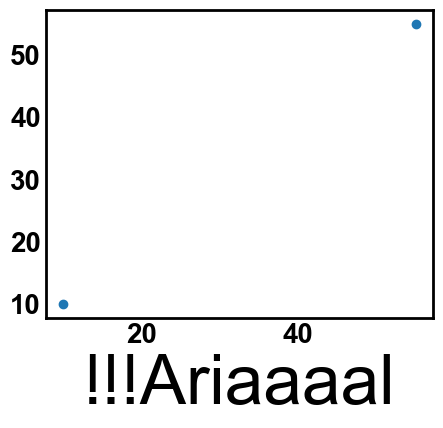

In [116]:
# check the font !!!!!!!!!!!!!!!!!!!!!
# switch to Arial
# if not working: delet ~/.catch/matplotlib
plt.rcParams["font.family"] = "Arial"
plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.fonttype'] = 42
mpl.font_manager.FontManager()
rc('font', weight='bold')
fig, ax = plt.subplots(figsize=(5, 4))
plt.scatter([10, 55], [10, 55])
ax.tick_params(axis='both', length=0, width=1.5,
               colors='black', grid_alpha=0, labelsize=20)
plt.xlabel('!!!Ariaaaal', fontname='Arial', fontsize=50)
l = np.arange(0, 73, 20)
l
#plt.xticks(l);

In [117]:
list(np.arange(0, 73, 10))

[0, 10, 20, 30, 40, 50, 60, 70]

# Fix the samples that rounding resulted in negative values for the last one.
 #97:  [ 0.31	0.09	0.20	0.40	0.01	-1.000000e-02 generated one]
 real one: [0.30701378 0.08708877 0.19961717 0.39865702 0.00716017]
 evaluated one:  [0.31 0.09 0.2 0.4 0.0 0.0]

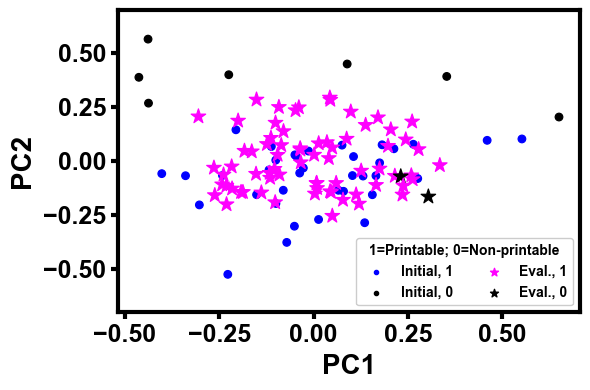

In [118]:
# Fix the samples that rounding resulted in
df_eval = pd.read_csv('new_evaluated_keep.csv',)
df_eval['Toughness(MJ/m3)'] = -df_eval['Toughness(MJ/m3)']
df_eval['Tensile_Strength(MPa)'] = -df_eval['Tensile_Strength(MPa)']
#df_eval_nozero = pd.read_csv('new_evaluated_nonzero_keep.csv',)
df_init = pd.read_csv('./Yuchao_20220816_keep.csv',)
df_init['Printability'] = df_init['Printability'].map(dict(Y=1, N=0))
x_eval = df_eval.iloc[:, 1:6]
x_init = df_init.iloc[:, 1:6]
# PCA Dimension Reduction
pca = PCA(n_components=2)
x_eval_pca = pca.fit_transform(x_eval)
x_init_pca = pca.fit_transform(x_init)

df_eval['pca1'] = x_eval_pca[:, 0]
df_eval['pca2'] = x_eval_pca[:, 1]

df_init['pca1'] = x_init_pca[:, 0]
df_init['pca2'] = x_init_pca[:, 1]

df_eval['initial'] = 'Eval.'
df_init['initial'] = 'Initial'
df = pd.concat([df_init, df_eval], axis=0)

# do not delet the non-printable cases.
fig, ax = plt.subplots(figsize=(6, 4))
hue = df['initial'].astype(str) + ', ' + df['Printability'].astype(str)
label = ['Init., Printable', 'Init., Non-printable',
         'Eval., Printable', 'Eval., Non-printable']
sns.scatterplot(data=df, x='pca1', y='pca2',
                markers=['.', '.', '*', '*'], edgecolor=None,
                palette=['blue', 'black', 'magenta', 'black'], hue=hue, style=hue,
                alpha=1, s=120,)  # label='Evaluated')
plt.ylim(-0.7, 0.7)


plt.legend(ncol=2, title='1=Printable; 0=Non-printable', framealpha=1)

ax.set_xlabel('PC1', fontsize='20', fontname='Arial',
              fontweight='bold', labelpad=5)
ax.set_ylabel('PC2', fontsize='20', fontname='Arial',
              fontweight='bold', labelpad=5)

ax.tick_params(direction='out', length=5, width=3, colors='black',
               grid_alpha=1, labelsize='18')

[i.set_linewidth(3) for i in ax.spines.values()]

plt.tight_layout()
#plt.title ('per {}, rand {}'.format(per, rand))
#plt.ylim(-25, 45)
plt.savefig('pca_printable_non.jpeg', dpi=500)


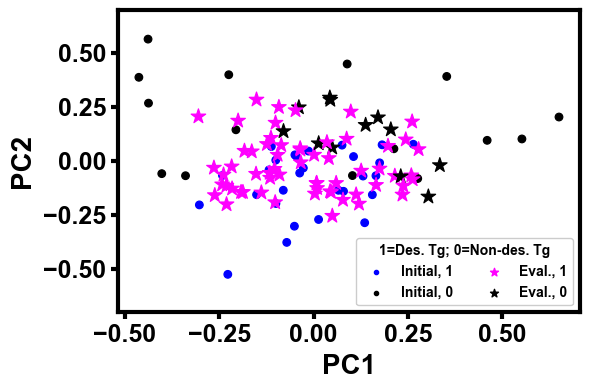

In [119]:
# Fix the samples that rounding resulted in
df_eval = pd.read_csv('new_evaluated_keep.csv',)
df_eval['Toughness(MJ/m3)'] = -df_eval['Toughness(MJ/m3)']
df_eval['Tensile_Strength(MPa)'] = -df_eval['Tensile_Strength(MPa)']
#df_eval_nozero = pd.read_csv('new_evaluated_nonzero_keep.csv',)
df_init = pd.read_csv('./Yuchao_20220816_keep.csv',)
df_init['Printability'] = df_init['Tg'].map(dict(Y=1, N=0))
x_eval = df_eval.iloc[:, 1:6]
x_init = df_init.iloc[:, 1:6]
# PCA Dimension Reduction
pca = PCA(n_components=2)
x_eval_pca = pca.fit_transform(x_eval)
x_init_pca = pca.fit_transform(x_init)

df_eval['pca1'] = x_eval_pca[:, 0]
df_eval['pca2'] = x_eval_pca[:, 1]

df_init['pca1'] = x_init_pca[:, 0]
df_init['pca2'] = x_init_pca[:, 1]

df_eval['initial'] = 'Eval.'
df_init['initial'] = 'Initial'
df = pd.concat([df_init, df_eval], axis=0)

Tg = df['Tg']
Tg_group = [1 if 9.9 < i < 60.1 else 0 for i in Tg]
df['Tg_group'] = Tg_group
# do not delet the non-printable cases.
fig, ax = plt.subplots(figsize=(6, 4))
hue = df['initial'].astype(str) + ', ' + df['Tg_group'].astype(str)
label = ['Init., Printable', 'Init., Non-printable',
         'Eval., Printable', 'Eval., Non-printable']
sns.scatterplot(data=df, x='pca1', y='pca2',
                markers=['.', '.', '*', '*'], edgecolor=None,
                palette=['blue', 'black', 'magenta', 'black'], hue=hue, style=hue,
                alpha=1, s=120,)  # label='Evaluated')
plt.ylim(-0.7, 0.7)


plt.legend(ncol=2, title='1=Des. Tg; 0=Non-des. Tg', framealpha=1)

ax.set_xlabel('PC1', fontsize='20', fontname='Arial',
              fontweight='bold', labelpad=5)
ax.set_ylabel('PC2', fontsize='20', fontname='Arial',
              fontweight='bold', labelpad=5)

ax.tick_params(direction='out', length=5, width=3, colors='black',
               grid_alpha=1, labelsize='18')

[i.set_linewidth(3) for i in ax.spines.values()]

plt.tight_layout()
#plt.title ('per {}, rand {}'.format(per, rand))
#plt.ylim(-25, 45)
plt.savefig('pca_tg_non.jpeg', dpi=500)


In [120]:
# Fix the samples that rounding resulted in
df_eval = pd.read_csv('new_evaluated_nonzero_keep.csv',)
df_eval['Toughness(MJ/m3)'] = -df_eval['Toughness(MJ/m3)']
df_eval['Tensile_Strength(MPa)'] = -df_eval['Tensile_Strength(MPa)']
#df_eval_nozero = pd.read_csv('new_evaluated_nonzero_keep.csv',)
df_init = pd.read_csv('./Yuchao_20220816_nonzero_keep.csv',)
df_init['Printability'] = df_init['Printability'].map(dict(Y=1, N=0))
x_eval = df_eval.iloc[:, 1:6]
x_init = df_init.iloc[:, 1:6]


In [121]:
# TSNE Dimension Reduction
tsne = TSNE(init='pca', n_iter=10000, learning_rate='auto',
            perplexity=9, random_state=10, verbose=1)
x_eval_tsne = tsne.fit_transform(x_eval)
x_init_tsne = tsne.fit_transform(x_init)

df_eval['tsne1'] = x_eval_tsne[:, 0]
df_eval['tsne2'] = x_eval_tsne[:, 1]

df_init['tsne1'] = x_init_tsne[:, 0]
df_init['tsne2'] = x_init_tsne[:, 1]


[t-SNE] Computing 28 nearest neighbors...
[t-SNE] Indexed 70 samples in 0.000s...
[t-SNE] Computed neighbors for 70 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 70 / 70
[t-SNE] Mean sigma: 0.114505
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.952919
[t-SNE] KL divergence after 1300 iterations: 0.430033
[t-SNE] Computing 28 nearest neighbors...
[t-SNE] Indexed 36 samples in 0.000s...
[t-SNE] Computed neighbors for 36 samples in 0.074s...
[t-SNE] Computed conditional probabilities for sample 36 / 36
[t-SNE] Mean sigma: 0.153229
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.258644
[t-SNE] KL divergence after 1750 iterations: 0.223922


In [122]:
# PCA Dimension Reduction
pca = PCA(n_components=2)

x_eval_pca = pca.fit_transform(x_eval)
x_init_pca = pca.fit_transform(x_init)

df_eval['pca1'] = x_eval_pca[:, 0]
df_eval['pca2'] = x_eval_pca[:, 1]

df_init['pca1'] = x_init_pca[:, 0]
df_init['pca2'] = x_init_pca[:, 1]


In [123]:
df_init['Printability'] = df_init['Printability'].map(dict(Y=1, N=0))

In [124]:
df_eval['initial'] = 'Eval.'
df_init['initial'] = 'Initial'
df = pd.concat([df_init, df_eval], axis=0)
X = df.iloc[:, 1:6]

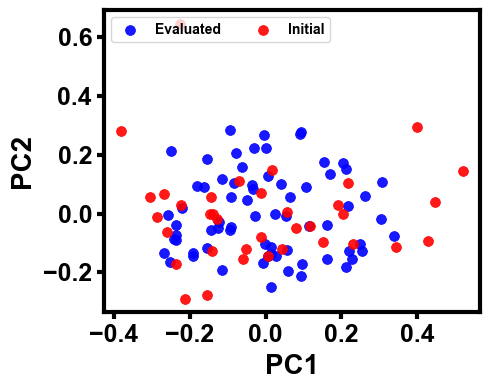

In [125]:
fig, ax = plt.subplots(figsize=(5, 4))
markers = ['o', 's', '*', 'v']
#['*', 's', 'o', 'v']
sns.scatterplot(data=df_eval, x='pca1', y='pca2',
                markers='*', edgecolor=None, color='blue',
                alpha=0.9, s=50,  label='Evaluated')

sns.scatterplot(data=df_init, x='pca1', y='pca2',
                markers=markers, edgecolor=None, color='red',
                alpha=0.9, s=50,  label='Initial')

ax.set_xlabel('PC1', fontsize='20', fontname='Arial',
              fontweight='bold', labelpad=5)
ax.set_ylabel('PC2', fontsize='20', fontname='Arial',
              fontweight='bold', labelpad=5)

ax.tick_params(direction='out', length=5, width=3, colors='black',
               grid_alpha=1, labelsize='18')

[i.set_linewidth(3) for i in ax.spines.values()]
plt.legend(ncol=2, loc='upper left')
plt.tight_layout()
#plt.title ('per {}, rand {}'.format(per, rand))
#plt.ylim(-25, 45)
plt.savefig('eval_init_samples_pca.jpeg', dpi=500)


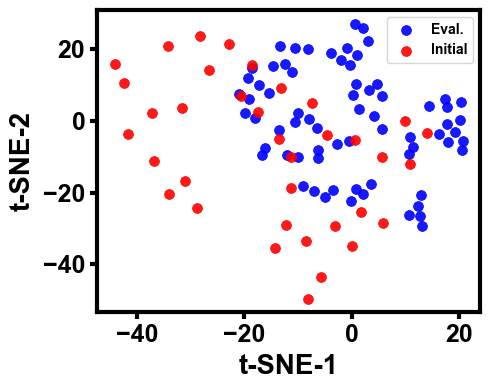

In [126]:
fig, ax = plt.subplots(figsize=(5, 4))
markers = ['o', 's', '*', 'v']
#['*', 's', 'o', 'v']
sns.scatterplot(data=df_eval, x='tsne1', y='tsne2',
                markers='*', edgecolor=None, color='blue',
                alpha=0.9, s=50, label='Eval.')

sns.scatterplot(data=df_init, x='tsne1', y='tsne2',
                markers=markers, edgecolor=None, color='red',
                alpha=0.9, s=50, label='Initial')
plt.legend()

ax.set_xlabel('t-SNE-1', fontsize='20', fontname='Arial',
              fontweight='bold', labelpad=5)
ax.set_ylabel('t-SNE-2', fontsize='20', fontname='Arial',
              fontweight='bold', labelpad=5)

ax.tick_params(direction='out', length=5, width=3, colors='black',
               grid_alpha=1, labelsize='18')

[i.set_linewidth(3) for i in ax.spines.values()]

plt.tight_layout()
#plt.title ('per {}, rand {}'.format(per, rand))
#plt.ylim(-25, 45)
plt.savefig('eval_init_samples_tsne.jpeg', dpi=500)


In [127]:
# PCA Dimension Reduction
pca = PCA(n_components=2)
x_pca = pca.fit_transform(X)

df['pca1'] = x_pca[:, 0]
df['pca2'] = x_pca[:, 1]


In [128]:
df_eval

,sample,R1(HA),R2(IA),R3(NVP),R4(AA),R5(HEAA),R6(IBOA),Printability,Tg,Tensile_Strength(MPa),Toughness(MJ/m3),Tensile_Strain_percentage,tsne1,tsne2,pca1,pca2,initial
0,44,0.29,0.00,0.06,0.23,0.31,0.11,1,56.4,29.22,0.62,3.20,-6.951508,-19.622292,-0.077364,0.207555,Eval.
1,45,0.23,0.00,0.07,0.31,0.33,0.06,1,60.8,30.68,0.70,4.24,-9.083335,-18.246260,-0.003977,0.266009,Eval.
2,46,0.37,0.17,0.10,0.04,0.20,0.12,1,44.2,36.98,0.94,4.40,14.406789,4.165526,-0.125444,-0.049165,Eval.
3,47,0.25,0.35,0.02,0.15,0.13,0.10,1,29.2,26.97,17.53,97.20,0.881926,10.403777,0.056874,-0.125230,Eval.
4,48,0.29,0.28,0.04,0.29,0.10,0.00,1,36.7,32.56,1.35,6.16,-7.868213,0.430284,0.024807,0.000154,Eval.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,111,0.11,0.02,0.00,0.34,0.19,0.34,1,65.8,30.46,0.62,3.80,-16.657022,-9.509528,0.090317,0.270511,Eval.
66,112,0.43,0.22,0.15,0.13,0.05,0.02,1,39.3,44.84,1.33,5.36,10.756840,-4.484246,-0.145156,-0.054346,Eval.
67,113,0.52,0.21,0.05,0.11,0.09,0.02,1,35.7,32.03,7.58,33.28,16.302450,-3.518289,-0.242724,-0.087237,Eval.
68,114,0.13,0.19,0.03,0.43,0.06,0.16,1,56.4,22.79,0.29,3.40,-13.487068,-2.462492,0.152901,0.175987,Eval.


In [129]:
df_eval['Tensile_Strength(MPa)'].shape

(70,)

In [130]:
Strength = df_eval['Tensile_Strength(MPa)']
Toughness = df_eval['Toughness(MJ/m3)']
Y_eval = []
for i, j in zip(Strength, Toughness):
    Y_eval.append([i, j])
Y_eval = np.array(Y_eval)
Y_eval.shape

(70, 2)

In [131]:
Y_eval = -Y_eval

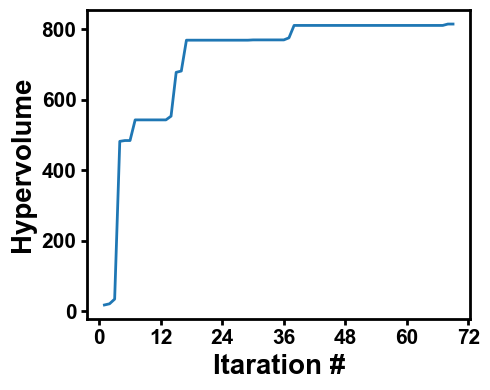

In [132]:
Strength = -df['Tensile_Strength(MPa)']
Toughness = -df['Toughness(MJ/m3)']
Y = []
for i, j in zip(Strength, Toughness):
    Y.append([i, j])
Y = np.array(Y)

plot_performance_metric(Y_eval, ['min', 'min'],)


In [133]:
# calculate the Pareto Front
pareto = find_pareto_front(Y)
pareto[:, 0]


array([-49.99, -32.03, -31.22, -17.82, -15.1 ])

In [134]:
df['Toughness(MJ/m3)']

0      2.33
1     12.47
2      0.69
3      0.70
4      2.15
      ...  
65     0.62
66     1.33
67     7.58
68     0.29
69    18.29
Name: Toughness(MJ/m3), Length: 106, dtype: float64

In [135]:
pareto_id = []
for i in range(len(df)):
    if df['Tensile_Strength(MPa)'].iloc[i] in -pareto[:, 0]:
        if df['Toughness(MJ/m3)'].iloc[i] in -pareto[:, 1]:
            pareto_id.append(i)
df_pareto = df.iloc[pareto_id]
df_pareto['Toughness(MJ/m3)']


14    25.76
16    22.56
36    25.02
37     2.75
67     7.58
Name: Toughness(MJ/m3), dtype: float64

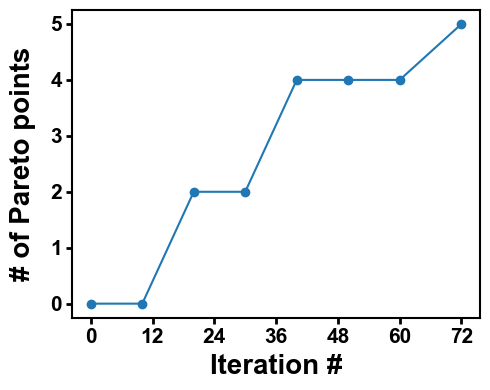

In [136]:
# manually find what iteration each pareto discoverd
# array([[-49.99,  -2.75] --> 38
#       [-32.03,  -7.58]--> 70
#      [-31.22, -22.56] --> 17
#      [-17.82, -25.02] --> 37
#      [-15.1 , -25.76]]) --> 15
fig, ax = plt.subplots(figsize=(5, 4))
iterations = np.arange(0, 72, 10)
iterations[-1] = 72
#array([  0,  10,  20,  30,  40,  50,  60, 115])
pareto_cont = [0, 0, 2, 2, 4, 4, 4, 5,]
plt.scatter(iterations, pareto_cont)
plt.plot(iterations, pareto_cont)

#plt.xticks([0, 20, 40, 60, 80, 100,])
ax.set_xlabel('Iteration #', fontsize='20', fontname='Arial',
              fontweight='bold', labelpad=5)
ax.set_ylabel('# of Pareto points', fontsize='20', fontname='Arial',
              fontweight='bold', labelpad=10)

ax.tick_params(direction='out', length=4, width=2, colors='black',
               grid_alpha=1, labelsize='15')

[i.set_linewidth(1.5) for i in ax.spines.values()]
plt.xticks(np.arange(0, 73, 12))
plt.tight_layout()
plt.savefig('numParet_iters.png', dpi=500)


In [137]:
iterations.shape

(8,)

In [138]:
iterations = np.arange(50, 121, 10)
iterations


array([ 50,  60,  70,  80,  90, 100, 110, 120])

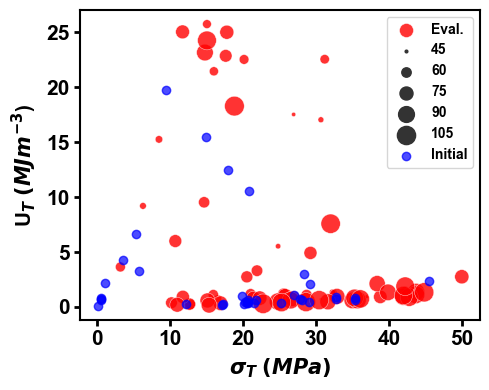

In [139]:
fig, ax = plt.subplots(figsize=(5, 4))
sns.scatterplot(x='Tensile_Strength(MPa)', y='Toughness(MJ/m3)',
                size='sample', color='red', sizes=(1, 200), label='Eval.',
                alpha=.8, palette=["red"], data=df_eval)
plt.scatter(df_init['Tensile_Strength(MPa)'],
            df_init['Toughness(MJ/m3)'], label='Initial',
            alpha=0.7, color='blue',)
plt.legend()
# plt.legend(['','','','','',
#           'Eval.','Init.'])


ax.set_xlabel('$\sigma$$_{T}$ $(MPa)$', fontsize='15',
              fontname='Arial', fontweight='bold', labelpad=5)
ax.set_ylabel('U$_T$ $({MJ}{m^{-3}}$)', fontsize='15',
              fontname='Arial', fontweight='bold', labelpad=5)

ax.tick_params(direction='out', length=4, width=2, colors='black',
               grid_alpha=1, labelsize='15')
#plt.scatter (-pareto[:, 0], -pareto[:, 1], facecolors='none', edgecolors='black')

[i.set_linewidth(1.5) for i in ax.spines.values()]
plt.tight_layout()
plt.savefig('evaluate_init.png', dpi=500)


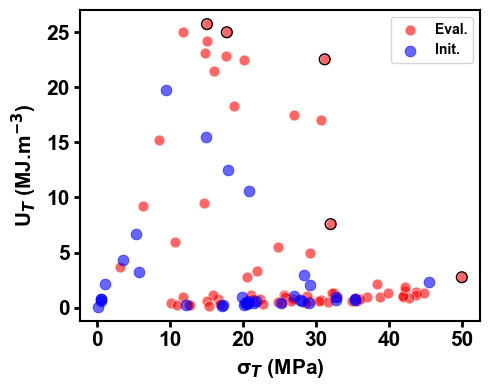

In [140]:
fig, ax = plt.subplots(figsize=(5, 4))
sns.scatterplot(x='Tensile_Strength(MPa)', y='Toughness(MJ/m3)',
                color='red', s=60, label='Eval.',
                alpha=.6, palette=["blue"], data=df_eval)

sns.scatterplot(x='Tensile_Strength(MPa)', y='Toughness(MJ/m3)',
                color='blue', s=60, label='Init.', edgecolor=None,
                alpha=.6, palette=["red"], data=df_init)
plt.legend()
ax.set_xlabel('σ$_{T}$ (MPa)', fontsize='15',
              fontname='Arial', fontweight='bold', labelpad=5)
ax.set_ylabel(r'U$_T$ (MJ.m$^{-3}$)', fontsize='15',
              fontname='Arial', fontweight='bold', labelpad=5)

ax.tick_params(direction='out', length=4, width=2, colors='black',
               grid_alpha=1, labelsize='15')
plt.scatter(-pareto[:, 0], -pareto[:, 1], facecolors='none',
            s=60, edgecolors='black', marker='o', alpha=1,)
#plt.plot(-pareto[:, 0], -pareto[:, 1], color='black')
plt.legend()
pareto_df = pd.DataFrame({})
pareto_df['strength'] = -pareto[:, 0]
pareto_df['toughness'] = -pareto[:, 1]
pareto_df_sort_str = pareto_df.sort_values(by='strength')
new_iters = np.arange(pareto_df_sort_str['strength'].iloc[0],
                      pareto_df_sort_str['strength'].iloc[-1], 0.1)

gfg_str = make_interp_spline(pareto_df_sort_str['strength'],
                             pareto_df_sort_str['toughness'], k=1)
strength_new = gfg_str(new_iters)
#plt.plot(new_iters, strength_new, '--k')

[i.set_linewidth(1.5) for i in ax.spines.values()]
plt.tight_layout()
plt.savefig('pareto_points.png', dpi=500)


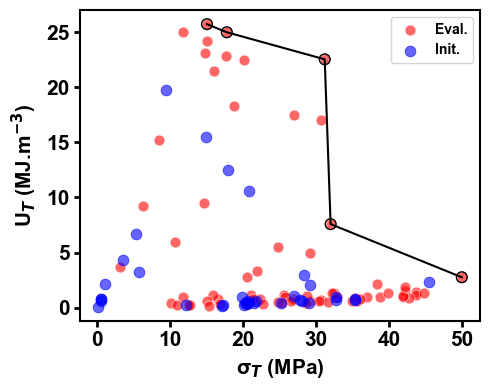

In [141]:
fig, ax = plt.subplots(figsize=(5, 4))
sns.scatterplot(x='Tensile_Strength(MPa)', y='Toughness(MJ/m3)',
                color='red', s=60, label='Eval.',
                alpha=.6, palette=["blue"], data=df_eval)

sns.scatterplot(x='Tensile_Strength(MPa)', y='Toughness(MJ/m3)',
                color='blue', s=60, label='Init.', edgecolor=None,
                alpha=.6, palette=["red"], data=df_init)
plt.legend()
ax.set_xlabel('σ$_{T}$ (MPa)', fontsize='15',
              fontname='Arial', fontweight='bold', labelpad=5)
ax.set_ylabel(r'U$_T$ (MJ.m$^{-3}$)', fontsize='15',
              fontname='Arial', fontweight='bold', labelpad=5)

ax.tick_params(direction='out', length=4, width=2, colors='black',
               grid_alpha=1, labelsize='15')
plt.scatter(-pareto[:, 0], -pareto[:, 1], facecolors='none',
            s=60, edgecolors='black', marker='o', alpha=1,)
plt.plot(-pareto[:, 0], -pareto[:, 1], color='black')
plt.legend()
pareto_df = pd.DataFrame({})
pareto_df['strength'] = -pareto[:, 0]
pareto_df['toughness'] = -pareto[:, 1]
pareto_df_sort_str = pareto_df.sort_values(by='strength')
new_iters = np.arange(pareto_df_sort_str['strength'].iloc[0],
                      pareto_df_sort_str['strength'].iloc[-1], 0.1)

gfg_str = make_interp_spline(pareto_df_sort_str['strength'],
                             pareto_df_sort_str['toughness'], k=1)
strength_new = gfg_str(new_iters)
#plt.plot(new_iters, strength_new, '--k')

[i.set_linewidth(1.5) for i in ax.spines.values()]
plt.tight_layout()
plt.savefig('paretofront_area.png', dpi=500)


In [142]:

print(u'\u1d40')

ᵀ


In [143]:
Y_eval = -Y_eval

In [144]:
def calc_hypervolume(Y_eval, ref_point, obj_type=None):
    '''
    Calculate hypervolume
    '''
    #Y = convert_minimization(Y, obj_type)

    return Hypervolume(ref_point=ref_point).calc(Y_eval)


hypervolume = calc_hypervolume(Y_eval, (0, 0))
print(hypervolume)


0.0


In [145]:
Strength = df_init['Tensile_Strength(MPa)']
Toughness = df_init['Toughness(MJ/m3)']
Y_initial = []
for i, j in zip(Strength, Toughness):
    Y_initial.append([i, j])
Y_initial = np.array(Y_initial)
Y_initial


array([[45.51,  2.33],
       [17.95, 12.47],
       [32.74,  0.69],
       [27.81,  0.7 ],
       [ 1.2 ,  2.15],
       [28.33,  2.97],
       [20.54,  0.32],
       [27.03,  1.05],
       [35.42,  0.64],
       [21.52,  0.4 ],
       [20.23,  0.23],
       [29.07,  0.45],
       [20.54,  0.41],
       [17.16,  0.17],
       [19.83,  0.99],
       [29.19,  2.06],
       [ 5.35,  6.68],
       [32.72,  0.93],
       [20.8 , 10.57],
       [25.27,  0.38],
       [20.76,  0.62],
       [14.97, 15.49],
       [20.74,  0.37],
       [ 5.83,  3.27],
       [20.33,  0.41],
       [28.13,  0.59],
       [21.79,  0.6 ],
       [ 9.55, 19.8 ],
       [ 3.67,  4.28],
       [ 0.57,  0.75],
       [ 0.53,  0.77],
       [ 0.59,  0.6 ],
       [ 0.2 ,  0.09],
       [35.33,  0.78],
       [17.35,  0.24],
       [12.22,  0.24]])

In [146]:
Strength = df_eval['Tensile_Strength(MPa)']
Toughness = df_eval['Toughness(MJ/m3)']
Y_eval = []
for i, j in zip(Strength, Toughness):
    Y_eval.append([i, j])
Y_eval = np.array(Y_eval)
Y_eval


array([[29.22,  0.62],
       [30.68,  0.7 ],
       [36.98,  0.94],
       [26.97, 17.53],
       [32.56,  1.35],
       [24.84,  5.53],
       [30.7 , 17.05],
       [32.28,  1.33],
       [ 6.34,  9.2 ],
       [20.44,  0.53],
       [ 8.53, 15.26],
       [16.59,  0.75],
       [21.56,  0.59],
       [42.27,  1.49],
       [15.1 , 25.76],
       [16.05, 21.46],
       [31.22, 22.56],
       [20.18, 22.54],
       [ 3.25,  3.64],
       [15.97,  1.12],
       [12.83,  0.23],
       [21.08,  1.18],
       [28.74,  1.09],
       [14.71,  9.53],
       [21.95,  3.3 ],
       [10.24,  0.38],
       [20.56,  2.74],
       [12.7 ,  0.26],
       [25.61,  1.15],
       [17.67, 22.87],
       [10.77,  6.  ],
       [29.27,  4.92],
       [11.8 ,  0.91],
       [38.83,  0.92],
       [21.46,  0.81],
       [11.76, 25.05],
       [17.82, 25.02],
       [49.99,  2.75],
       [22.32,  0.8 ],
       [16.94,  0.34],
       [11.03,  0.2 ],
       [15.17,  0.59],
       [25.8 ,  0.97],
       [26.

In [147]:
Y = -Y


In [148]:
np.min(Y_eval[:, 0])


3.25

In [149]:
(np.sqrt(1e-3), np.sqrt(1e3))


(0.03162277660168379, 31.622776601683793)

In [150]:
n_var = 5
nu1 = 1
nu2 = 1
main_kernel1 = Matern(length_scale=1*np.ones(n_var),
                      length_scale_bounds=(np.sqrt((13e-1)), np.sqrt(5e5)), nu=0.5*nu1)

main_kernel2 = Matern(length_scale=2*np.ones(n_var),
                      length_scale_bounds=(np.sqrt((1.65e-1)), np.sqrt(1e3)), nu=0.5*nu2)

kernel1 = ConstantKernel(constant_value=1.0,
                         constant_value_bounds=(np.sqrt(1e-5), np.sqrt(1000))) * main_kernel1 + \
    ConstantKernel(constant_value=1.0,
                   constant_value_bounds=(np.exp(-100), np.exp(0)))

kernel2 = ConstantKernel(constant_value=1.0,
                         constant_value_bounds=(np.sqrt(0.01), np.sqrt(35))) * main_kernel2

kernel2 = ConstantKernel(constant_value=1.0,
                         constant_value_bounds=(np.sqrt(1e-5), np.sqrt(100))) * \
    main_kernel2 + \
    ConstantKernel(constant_value=1.0,
                   constant_value_bounds=(np.exp(-10), np.exp(0)))
# RBF kernel
#main_kernel = RBF(length_scale=0.01*np.ones(n_var), length_scale_bounds=(np.sqrt(1e-3), np.sqrt(1e5)))
#kernel = ConstantKernel(constant_value=1.0, constant_value_bounds=(np.sqrt(6e-1), np.sqrt(0.2e3))) * main_kernel
#kernel = ConstantKernel(constant_value=1.0, constant_value_bounds=(np.sqrt(6e-1), np.sqrt(0.2e2))) * RBF(length_scale=10, length_scale_bounds=(0.0, 10.0)) + 50*main_kernel


In [151]:
def constrained_optimization(obj_func, initial_theta, bounds):
    '''
    Customized version of constrained optimization to avoid convergence warning.
    '''
    opt_res = minimize(obj_func, initial_theta,
                       method="L-BFGS-B", jac=True, bounds=bounds,)
    # NOTE: Temporarily disable the checking below because of the numerical instability sometimes.
    _check_optimize_result("lbfgs", opt_res)
    return opt_res.x, opt_res.fun


gpr_strength = GaussianProcessRegressor(
    kernel=kernel1,
    optimizer=constrained_optimization,
    alpha=0.2
)
gpr_toughness = GaussianProcessRegressor(
    kernel=kernel1,
    optimizer=constrained_optimization,
    alpha=0.3
)


In [152]:
range(0, len(Y_eval))

range(0, 70)

In [153]:
errors_strength0 = []
pred_strength = []
sdt_strength = []
i = 0
X = np.array(X)
Y = np.array(Y)
for i in range(0, len(Y_eval)):
    gpr_strength = gpr_strength.fit(
        X[0:len(Y_initial)+i, :], Y[0:len(Y_initial)+i, 0])
    x_next = np.array(X[len(Y_initial) + i, :])
    x_next = x_next.reshape(1, 5)
    y_next = np.array(Y[len(Y_initial) + i, 0])
    y_next = y_next.reshape(1, 1)
    try:
        y_nexts = np.array(Y[len(Y_initial) + i: len(Y_initial) + i+5, 0])
        y_nexts = y_nexts.reshape(5, 1)
        x_nexts = np.array(X[len(Y_initial) + i: len(Y_initial) + i+5, :])
        x_nexts = x_nexts.reshape(5, 5)
        score_strength = gpr_strength.score(x_nexts, y_nexts)
        #print (score_strength)
    except:
        pass

    gpr_strength_predict = gpr_strength.predict(x_next, return_std=True)
    pred_strength.append([gpr_strength_predict[0][0], y_next[0][0]])
    sdt_strength.append(gpr_strength_predict[1][0])

    #print (gpr_strength_predict, y_next)

    error = abs(gpr_strength_predict[0] - y_next)/y_next

    #print (error)
    errors_strength0.append(error)

errors_toughness0 = []
pred_toughness = []
sdt_toughness = []
for i in range(0, len(Y_eval)):
    gpr_toughness = gpr_toughness.fit(
        X[0:len(Y_initial)+i, :], Y[0:len(Y_initial)+i, 1])

    x_next = np.array(X[len(Y_initial) + i, :])
    x_next = x_next.reshape(1, 5)
    y_next = np.array(Y[len(Y_initial) + i, 1])
    y_next = y_next.reshape(1, 1)
    try:
        y_nexts = np.array(Y[len(Y_initial)+i: len(Y_initial)+i+5, 1])
        y_nexts = y_nexts.reshape(5, 1)
        x_nexts = np.array(X[len(Y_initial)+i: len(Y_initial)+i+5, :])
        x_nexts = x_nexts.reshape(5, 5)
        score_toughness = gpr_toughness.score(x_nexts, y_nexts)
        #print (score_toughness)
    except:
        pass

    gpr_toughness_predict = gpr_toughness.predict(x_next, return_std=True)
    pred_toughness.append([gpr_toughness_predict[0][0], y_next[0][0]])
    sdt_toughness.append(gpr_toughness_predict[1][0])
    # print (gpr_toughness_ppred_strength
    # to not divide by a <1 number
    error = abs(gpr_toughness_predict[0] - y_next)/(y_next+1)
    errors_toughness0.append(error)

[gpr_toughness_predict[0], y_next[0][0]]


/home/kianoosh/anaconda3/envs/autooed/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 31.622776601683793. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/kianoosh/anaconda3/envs/autooed/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1.140175425099138. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/kianoosh/anaconda3/envs/autooed/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified lower bound 1.140175425099138. Decreasing the bound and calling fit again may find a

/home/kianoosh/anaconda3/envs/autooed/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 31.622776601683793. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/kianoosh/anaconda3/envs/autooed/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1.140175425099138. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/kianoosh/anaconda3/envs/autooed/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified lower bound 1.140175425099138. Decreasing the bound and calling fit again may find a

[array([2.30827327]), 18.29]

PearsonRResult(statistic=0.490878497091275, pvalue=1.600720075423631e-05)
0.167130673353434
PearsonRResult(statistic=0.6240555845252583, pvalue=7.838835192848658e-09)
0.3840806856476847


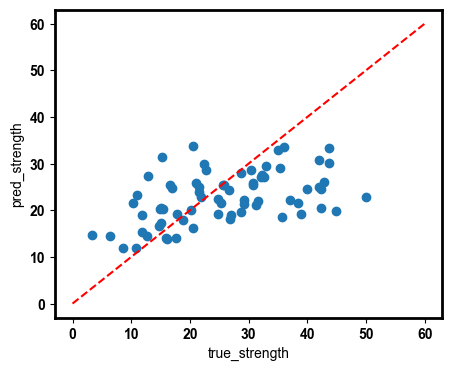

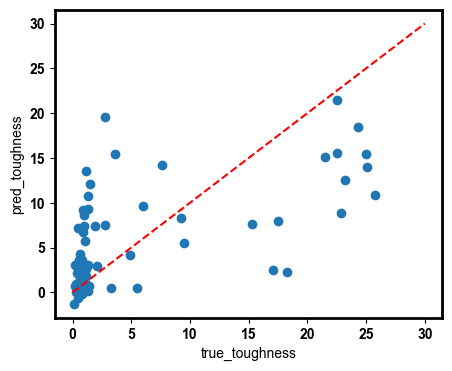

In [154]:
fig, ax = plt.subplots(figsize=(5, 4))
start_index = 0
end_index = 100
# pred_strength = [gp_pred, true_value]
pred_strength = np.array(pred_strength)
plt.scatter(pred_strength[start_index:end_index, 1],
            pred_strength[start_index:end_index, 0])
plt.xlabel('true_strength')
plt.ylabel('pred_strength')
plt.plot([0, 60], [0, 60], '--r')
# best rho = 0.496, r2 = 0.165
print(pearsonr(pred_strength[start_index:end_index,
      0], pred_strength[start_index:end_index, 1]))
print(r2_score(pred_strength[start_index:end_index,
      1], pred_strength[start_index:end_index, 0], ))
fig, ax = plt.subplots(figsize=(5, 4))
# pred_strength = [gp_pred, true_value]
pred_toughness = np.array(pred_toughness)
pred_toughness[:, 0]
plt.scatter(pred_toughness[start_index:end_index, 1],
            pred_toughness[start_index:end_index, 0])
plt.plot([0, 30], [0, 30], '--r')
plt.xlabel('true_toughness')
plt.ylabel('pred_toughness')
# best rho = 0.624, r2 = 0.384
print(pearsonr(pred_toughness[start_index:end_index, 0],
               pred_toughness[start_index:end_index, 1]))
print(r2_score(pred_toughness[start_index:end_index, 1],
               pred_toughness[start_index:end_index, 0]))


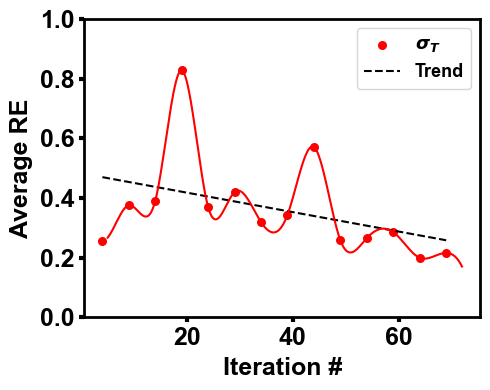

In [155]:
# 86, 103
errors_strength_ = errors_strength0.copy()
errors_toughness_ = errors_toughness0.copy()
errors_strength = np.array(errors_strength0).reshape(len(Y_eval), 1)
errors_toughness = np.array(errors_toughness0).reshape(len(Y_eval), 1)

# calculates the average over every n evaluation
n = 5
iters = list(np.arange(n-1, len(Y_eval)+4, n))
x_iter = iters
avgerrors_strength = np.average(errors_strength.reshape(-1, n), axis=1)
#avgerrors_strength[8] = 0.4
avgerrors_toughness = np.average(errors_toughness.reshape(-1, n), axis=1)

new_iters = np.arange(48-43, 115.1-43, 0.1)
gfg_str = make_interp_spline(x_iter, avgerrors_strength, bc_type='clamped',)
# bc_type='clamped', k=3)#k=2)
gfg_tough = make_interp_spline(x_iter, avgerrors_toughness, bc_type='clamped', )


strength_new = gfg_str(new_iters)
toughness_new = gfg_tough(new_iters)

fig, ax = plt.subplots(figsize=(5, 4))
plt.scatter(x_iter,
            avgerrors_strength, s=30, alpha=1, color='red')
# calculate equation for trendline
x = np.arange(0, len(Y_eval), n) + n + 43
x = list(x)
y = avgerrors_strength
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
# add trendline to plot
plt.plot(x_iter, p(x), '--k')

# plt.scatter (list(np.arange(0, len(Y_eval), n) + n),
#         avgerrors_toughness, s=30, alpha=0.7, color='blue')

# calculate equation for trendline
x = (np.arange(0, len(Y_eval), n) + n)
x = x + 43
x = list(x)
y = avgerrors_toughness
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
# add trendline to plot
#plt.plot(x, p(x), '--b')

plt.plot(new_iters , strength_new, color='red', label='$\sigma$$_{T}$', alpha=1)
#plt.plot(new_iters + n, toughness_new, color='blue', label='Toughness', alpha=0.7)
plt.legend(['$\sigma$$_{T}$', 'Trend'], fontsize=13)
ax.set_xlabel('Iteration #', fontsize='18', fontname='Arial',
              fontweight='bold', labelpad=5)
ax.set_ylabel('Average RE', fontsize='18', fontname='Arial',
              fontweight='bold', labelpad=5)

ax.tick_params(direction='out', length=3.5, width=3, colors='black',
               grid_alpha=1, labelsize='18')
[i.set_linewidth(2) for i in ax.spines.values()]
#ticks = [ 44,  60,  80,  100,  115]
#plt.xticks(ticks)
#plt.legend([], title='$\sigma$$_{T}$', frameon=False, title_fontsize=15)#fontname='Arial',)
plt.ylim((0, 1))
plt.tight_layout()
plt.savefig('AverageRE_strength.png', dpi=500)


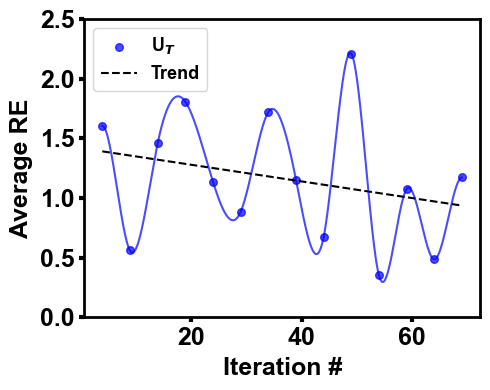

In [156]:
errors_strength_ = errors_strength0.copy()
errors_toughness_ = errors_toughness0.copy()
errors_strength = np.array(errors_strength0).reshape(len(Y_eval), 1)
errors_toughness = np.array(errors_toughness0).reshape(len(Y_eval), 1)

# calculates the average over every n evaluation
n = 5
iters = list(np.arange(n-1, len(Y_eval)+4, n))
x_iter = iters
avgerrors_strength = np.average(errors_strength.reshape(-1, n), axis=1)
#avgerrors_strength[8] = 0.4
avgerrors_toughness = np.average(errors_toughness.reshape(-1, n), axis=1)

new_iters = np.arange(4, 112.1-43, 0.1)
gfg_str = make_interp_spline(x_iter, avgerrors_strength, bc_type='natural',)
# bc_type='clamped', k=3)#k=2)
gfg_tough = make_interp_spline(
    x_iter, avgerrors_toughness, k=3, bc_type='clamped', )


strength_new = gfg_str(new_iters)
toughness_new = gfg_tough(new_iters)

fig, ax = plt.subplots(figsize=(5, 4))
# plt.scatter (list(np.arange(0, len(Y_eval), n) + n),
#          avgerrors_strength, s=30, alpha=1, color='red')
# calculate equation for trendline
x = list(np.arange(0, len(Y_eval), n) + n)
y = avgerrors_strength
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
# add trendline to plot
#plt.plot(x, p(x), '--r')

plt.scatter(x_iter,
            avgerrors_toughness, s=30, alpha=0.7, color='blue')

# calculate equation for trendline
x = (np.arange(0, len(Y_eval), n) + n + 39)
x = list(x)
y = avgerrors_toughness
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
# add trendline to plot
plt.plot(x_iter, p(x), '--k')

#plt.plot(new_iters + n, strength_new, color='red', label='Strength', alpha=0.7)
plt.plot(new_iters, toughness_new,
         color='blue', label='Toughness', alpha=0.7)
plt.legend(['U$_T$', 'Trend'], fontsize=13)
ax.set_xlabel('Iteration #', fontsize='18', fontname='Arial',
              fontweight='bold', labelpad=5)
ax.set_ylabel('Average RE', fontsize='18', fontname='Arial',
              fontweight='bold', labelpad=5)

ax.tick_params(direction='out', length=3.5, width=3, colors='black',
               grid_alpha=1, labelsize='18')
[i.set_linewidth(2) for i in ax.spines.values()]
#ticks = [ 44,  60,  80,  100,  115]
#plt.xticks(ticks)
plt.ylim((0, 2.5))

plt.tight_layout()
plt.savefig('AverageRE_toughness.png', dpi=500)

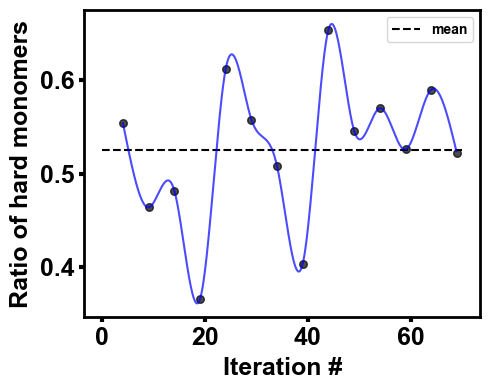

In [157]:
x_eval = np.array(x_eval)
# calculates the average over every n evaluation
n = 5
iters = list(np.arange(n-1, len(Y_eval)+4, n))
x_iter = iters
avgerrors_strength = np.average(pred_strength[:, 0].reshape(-1, n), axis=1)

x_eval_hard = x_eval[:, 2].ravel() + x_eval[:, 3].ravel() + x_eval[:, 4].ravel() + \
    np.round(1-(x_eval[:, 2].ravel() + x_eval[:, 3].ravel() + x_eval[:,
             4].ravel() + x_eval[:, 0].ravel() + x_eval[:, 1].ravel()), 2)
#x_eval_hard = 1-(x_eval [:, 0].ravel() + x_eval [:, 1].ravel() )
avg_x_eval_hard = np.average(x_eval_hard.reshape(-1, n), axis=1)
#plt.scatter (np.arange(0, len(avg_x_eval_hard)), avg_x_eval_hard,)

fig, ax = plt.subplots(figsize=(5, 4))
plt.scatter(x_iter,
            avg_x_eval_hard, s=30, alpha=0.7, color='black')

new_iters = np.arange(4, 69, 0.1)
gfg_str = make_interp_spline(
    x_iter, avg_x_eval_hard, k=3, bc_type='natural', check_finite=False)

strength_new = gfg_str(new_iters)
plt.plot([0, 70], [np.mean(x_eval_hard), np.mean(
    x_eval_hard)], '--k', label='mean')
plt.legend()
plt.plot(new_iters, strength_new, color='blue', label='Strength', alpha=0.7)
plt.xlabel('Sample ID')
plt.ylabel('Ratio of hard monomers')

ax.set_xlabel('Iteration #', fontsize='18', fontname='Arial',
              fontweight='bold', labelpad=5)
ax.set_ylabel('Ratio of hard monomers', fontsize='18',
              fontname='Arial', fontweight='bold', labelpad=5)

ax.tick_params(direction='out', length=3.5, width=3, colors='black',
               grid_alpha=1, labelsize='18')
[i.set_linewidth(2) for i in ax.spines.values()]
#ticks = [ 44,  60,  80,  100,  115]
#plt.xticks(ticks)
plt.tight_layout()
plt.savefig('hardmonomers_iter.png', dpi=500)


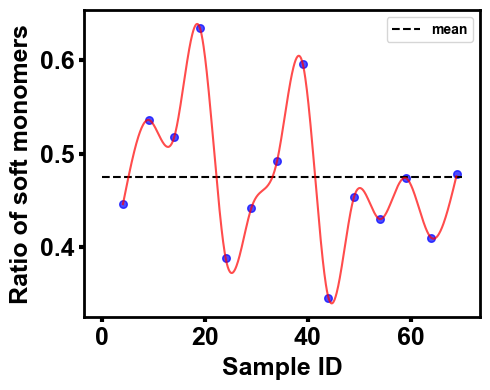

In [158]:
x_eval = np.array(x_eval)
# calculates the average over every n evaluation
n = 5
iters = list(np.arange(n-1, len(Y_eval)+4, n))
x_iter = iters
avgerrors_strength = np.average(pred_strength[:, 0].reshape(-1, n), axis=1)
x_eval_soft = x_eval[:, 0].ravel() + x_eval[:, 1].ravel()
avg_x_eval_soft = np.average(x_eval_soft.reshape(-1, n), axis=1)
#plt.scatter (np.arange(0, len(avg_x_eval_soft)), avg_x_eval_soft,)

fig, ax = plt.subplots(figsize=(5, 4))
plt.scatter(x_iter,
            avg_x_eval_soft, s=30, alpha=0.7, color='blue')

new_iters = np.arange(4, 69, 0.1)
gfg_str = make_interp_spline(
    x_iter, avg_x_eval_soft, k=3, bc_type='natural', check_finite=False)

strength_new = gfg_str(new_iters)
plt.plot([0, 70], [np.mean(x_eval_soft), np.mean(
    x_eval_soft)], '--k', label='mean')
plt.legend()
plt.plot(new_iters, strength_new, color='red', label='Strength', alpha=0.7)
plt.xlabel('Sample ID')
plt.ylabel('Ratio of soft monomers')

ax.set_xlabel('Sample ID', fontsize='18', fontname='Arial',
              fontweight='bold', labelpad=5)
ax.set_ylabel('Ratio of soft monomers', fontsize='18',
              fontname='Arial', fontweight='bold', labelpad=5)

ax.tick_params(direction='out', length=3.5, width=3, colors='black',
               grid_alpha=1, labelsize='18')
[i.set_linewidth(2) for i in ax.spines.values()]
#ticks = [ 44,  60,  80,  100,  115]
#plt.xticks(ticks)
plt.tight_layout()
plt.savefig('softmonomers_iter.png', dpi=500)


In [159]:
gpr_strength.fit(X, Y[:, 0],)
gpr_toughness.fit(X, Y[:, 1])

/home/kianoosh/anaconda3/envs/autooed/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 31.622776601683793. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/kianoosh/anaconda3/envs/autooed/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1.140175425099138. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/kianoosh/anaconda3/envs/autooed/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified lower bound 1.140175425099138. Decreasing the bound and calling fit again may find a

GaussianProcessRegressor(alpha=0.3,
                         kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1], nu=0.5) + 1**2,
                         optimizer=<function constrained_optimization at 0x7f23ab2a7d30>)

/tmp/ipykernel_8865/4010842294.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pareto['soft'] = df_pareto['R1(HA)'] + df_pareto['R2(IA)']
/tmp/ipykernel_8865/4010842294.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pareto['hard'] = df_pareto['R3(NVP)'] + df_pareto['R4(AA)'] +\


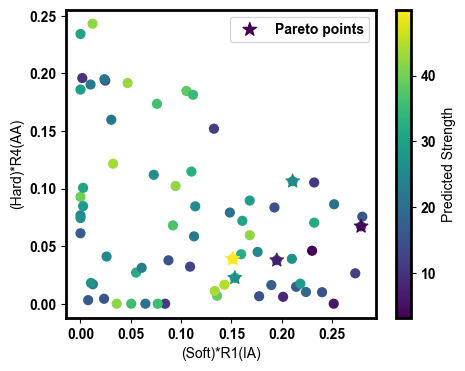

In [160]:
# plot each two of the input paramters for the evaluated samples
n_dims = 5
fig, ax = plt.subplots(1, 1,
                       figsize=(5, 4))
#plt.xlim(0, 1)
#plt.ylim(0, 1)
df_eval['soft'] = df_eval['R1(HA)'] + df_eval['R2(IA)']
df_eval['hard'] = df_eval['R3(NVP)'] + df_eval['R4(AA)'] +\
    df_eval['R5(HEAA)']

df_pareto['soft'] = df_pareto['R1(HA)'] + df_pareto['R2(IA)']
df_pareto['hard'] = df_pareto['R3(NVP)'] + df_pareto['R4(AA)'] +\
    df_pareto['R5(HEAA)']

Ratios = ['R1(HA)',	'R2(IA)',	'R3(NVP)',	'R4(AA)',
          'R5(HEAA)',	'R6(IBOA)', 'soft', 'hard']
""" 
cs = ax.scatter('soft', 'hard',
                c='Tensile_Strength(MPa)', data=df_eval,
                s=40, cmap='viridis')
"""
cs = ax.scatter(df_eval['soft']*df_eval['R2(IA)'],
                df_eval['hard']*df_eval['R5(HEAA)'],
                c=df_eval['Tensile_Strength(MPa)'],
                s=40, cmap='viridis')

fig.colorbar(cs, ax=ax, label='Predicted Strength')
#plt.plot([0, 1], [1, 0])
""" 
ax.scatter('soft', 'hard', data=df_pareto, c='Tensile_Strength(MPa)',
           s=200, marker='*')
"""
ax.scatter(df_pareto['soft']*df_pareto['R2(IA)'],
           df_pareto['hard']*df_pareto['R5(HEAA)'],
           c=df_pareto['Tensile_Strength(MPa)'],
           s=100, marker='*', label='Pareto points')
plt.xlabel('(Soft)*R1(IA)')
plt.ylabel('(Hard)*R4(AA)')
plt.legend()


In [161]:
"""
n_dims = 5
step = 0.055
fig, ax = plt.subplots(n_dims, n_dims,
                       figsize=(3 * n_dims, 3 * n_dims))
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95,
                    hspace=0.02, wspace=0.02)
Ratios = ['R1(HA)',	'R2(IA)', 'R3(NVP)',
          'R4(AA)', 'R5(HEAA)', 'R6(IBOA)']
for i in range(n_dims):
    for j in range(n_dims):
        if i == j:
            if i == 0:
                ax_ = ax[i, j]
                ax_.xaxis.set_label_position("top")
                ax_.xaxis.tick_top()
                ax_.set_xlabel(Ratios[j], fontweight='bold', fontsize=12)
                ax_.set_ylabel('Rel. abundance', fontweight='bold', fontsize=12)
                min = np.min(df_eval[Ratios[j]])
                max = np.max(df_eval[Ratios[j]])
                ax_.hist(Ratios[j], data=df_eval, color='blue', density=True,
                         bins=np.arange(min, max+0.1, step=step), alpha=0.4)

                min = np.min(df_init[Ratios[j]])
                max = np.max(df_init[Ratios[j]])
                ax_.hist(Ratios[j], data=df_init, bins=np.arange(min, max+0.1, step=step),
                         density=True, color='red', alpha=0.4)

            else:
                ax_ = ax[i, j]
                min = np.min(df_eval[Ratios[j]])
                max = np.max(df_eval[Ratios[j]])
                ax_.hist(Ratios[j], data=df_eval, color='blue', density=True,
                         bins=np.arange(min, max+0.1, step=step),
                         orientation='horizontal', alpha=0.4)

                min = np.min(df_init[Ratios[j]])
                max = np.max(df_init[Ratios[j]])
                ax_.hist(Ratios[j], data=df_init, bins=np.arange(min, max+0.1, step=step),
                         density=True, orientation='horizontal', color='red', alpha=0.4)
                if i != 0:
                    ax_.xaxis.set_label_position("top")
                    ax_.xaxis.tick_top()
                    ax_.set_xlabel('Rel. abundance', fontweight='bold', fontsize=12)
                    ax_.set_yticklabels([])
                    ax_.tick_params('y', length=0, width=0, )

                else:
                    ax_.set_ylabel(Ratios[j], fontweight='bold', fontsize=12)
                    ax_.xaxis.set_label_position("top")
                    ax_.xaxis.tick_top()
                    ax_.set_xlabel('Rel. abundance', fontweight='bold', fontsize=12)

        elif i > j:
            ax_ = ax[i, j]
            ax_.scatter(Ratios[j], Ratios[i], c='red',
                        data=df_init, s=40,)
            ax_.scatter(Ratios[j], Ratios[i], c='sample',
                        data=df_eval, s=40, cmap='Blues')
            if j == 0:
                ax_.set_ylabel('{}'.format(Ratios[i]), fontweight='bold', fontsize=12)
                if i != (n_dims-1):
                    ax_.set_xticklabels([])
                    ax_.tick_params('x', length=0, width=0, )
            if i == (n_dims-1):
                ax_.set_xlabel('{}'.format(
                    Ratios[j]), fontweight='bold', fontsize=12)
            if i != (n_dims-1):
                if j != 0:
                    ax_.tick_params('both', length=0, width=0, )
                    ax_.set_xticklabels([])
                    ax_.set_yticklabels([])
            if i == (n_dims-1):
                if j != 0:
                    ax_.tick_params('y', length=0, width=0, )
                    ax_.set_yticklabels([])
            ax_.scatter(Ratios[j], Ratios[i], data=df_pareto,
                        color='yellow', edgecolors='black',
                        s=200, marker='*')
            #print(Ratios[j], Ratios[i])
        if j > i:
            ax_ = ax[i, j]
            ax_.axis("off")
#plt.legend(['Evaluated', 'Initial'])
plt.savefig('hist_all_input.png', dpi=500)
"""

'\nn_dims = 5\nstep = 0.055\nfig, ax = plt.subplots(n_dims, n_dims,\n                       figsize=(3 * n_dims, 3 * n_dims))\nfig.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95,\n                    hspace=0.02, wspace=0.02)\nRatios = [\'R1(HA)\',\t\'R2(IA)\', \'R3(NVP)\',\n          \'R4(AA)\', \'R5(HEAA)\', \'R6(IBOA)\']\nfor i in range(n_dims):\n    for j in range(n_dims):\n        if i == j:\n            if i == 0:\n                ax_ = ax[i, j]\n                ax_.xaxis.set_label_position("top")\n                ax_.xaxis.tick_top()\n                ax_.set_xlabel(Ratios[j], fontweight=\'bold\', fontsize=12)\n                ax_.set_ylabel(\'Rel. abundance\', fontweight=\'bold\', fontsize=12)\n                min = np.min(df_eval[Ratios[j]])\n                max = np.max(df_eval[Ratios[j]])\n                ax_.hist(Ratios[j], data=df_eval, color=\'blue\', density=True,\n                         bins=np.arange(min, max+0.1, step=step), alpha=0.4)\n\n              

In [162]:
"""
n_dims = 5
step = 0.055
min_z, max_z = -0.2, 10
X_ratios = df.iloc[:, 1:6]

fig, ax = plt.subplots(n_dims, n_dims,
                       figsize=(3 * n_dims, 3 * n_dims))
fig.subplots_adjust(left=0.06, right=0.95, bottom=0.06, top=0.95,
                    hspace=0.032, wspace=0.032)
Ratios = ['R1(HA)',	'R2(IA)', 'R3(NVP)',
          'R4(AA)', 'R5(HEAA)', 'R6(IBOA)']
color = ['blue' if i > 1 else 'red']
for i in range(n_dims):
    for j in range(n_dims):
        color = 'red' if i > 1 else 'blue'
        if i == j:
            ax_ = ax[i, j]
            ax_.set_yticks((2, 4, 6, 8, 10))
            pd_results = partial_dependence(gpr_toughness, X_ratios, features=[i],
                                            grid_resolution=100, percentiles=(0.05, 0.095))
            ratio = np.array(pd_results["values"])[0]
            part_dep = np.array(pd_results["average"])[0]

            ax_.plot(ratio, part_dep, color=color, markersize=20, linewidth=2)
            ax_.scatter(ratio, part_dep, color='black', s=10,)

            ax_.xaxis.set_label_position("top")
            ax_.xaxis.tick_top()
            ax_.set_xlabel('{}'.format(
                Ratios[i]), fontweight='bold', fontsize=20, labelpad=5)
            ax_.yaxis.set_label_position("right")
            ax_.yaxis.tick_right()
            ax_.set_ylabel('PD',
                           fontweight='bold', fontsize=20, fontname='Arial', )
            ax_.tick_params('y', length=0, width=0, )
            ax_.set_ylim(min_z, max_z)
            ax_.tick_params(direction='out', length=5, width=3, colors='black',
                            grid_alpha=1, labelsize='20')

        elif i > j:
            ax_ = ax[i, j]
            features = [j, i]
            pd_inter_results = partial_dependence(gpr_toughness, X_ratios,
                                                  features=features, method='brute',
                                                  kind='average', grid_resolution=100, percentiles=(0.05, 0.095))
            XX, YY = np.meshgrid(
                pd_inter_results['values'][0], pd_inter_results['values'][1])
            Z = pd_inter_results['average'][0].T
            Z_level = np.linspace(min_z, max_z, num=8)
            CS = ax_.contour(XX, YY, Z, levels=Z_level,
                             linewidths=0.5, colors="k")
            ax_.contourf(
                XX,
                YY,
                Z,
                levels=Z_level,
                vmin=Z_level[0],
                vmax=Z_level[-1],
            )
            if i == 1 and j == 0:
                ax_.set_yticks((0.1, 0.2, 0.4))
            ax_.tick_params(direction='out', length=5, width=3, colors='black',
                            grid_alpha=1, labelsize='20')

            ax_.tick_params('x', direction='out', length=5, width=3, colors='black',
                            grid_alpha=1, labelsize='20', rotation=90)
            ax_.clabel(CS, fmt="%2.2f", colors="k", fontsize=10, inline=True)
            ax_.scatter(Ratios[j], Ratios[i], data=df_pareto,
                        color='yellow', edgecolors='black',
                        s=200, marker='*')

            if j == 0:
                ax_.set_ylabel('{}'.format(Ratios[i]), fontweight='bold',
                               fontsize=20, fontname='Arial', labelpad=5)
                if i != (n_dims-1):
                    ax_.set_xticklabels([])
                    ax_.tick_params('x', length=0, width=0, )
            if i == (n_dims-1):
                ax_.set_xlabel('{}'.format(Ratios[j]), fontweight='bold',
                               fontsize=20, fontname='Arial')

            if i != (n_dims-1):
                if j != 0:
                    ax_.tick_params('both', length=0, width=0, )
                    ax_.set_xticklabels([])
                    ax_.set_yticklabels([])
            if i == (n_dims-1):
                if j != 0:
                    ax_.tick_params('y', length=0, width=0, )
                    ax_.set_yticklabels([])
        if j > i:
            ax_ = ax[i, j]
            ax_.axis("off")
plt.savefig('pd_tough', dpi=500)
"""

'\nn_dims = 5\nstep = 0.055\nmin_z, max_z = -0.2, 10\nX_ratios = df.iloc[:, 1:6]\n\nfig, ax = plt.subplots(n_dims, n_dims,\n                       figsize=(3 * n_dims, 3 * n_dims))\nfig.subplots_adjust(left=0.06, right=0.95, bottom=0.06, top=0.95,\n                    hspace=0.032, wspace=0.032)\nRatios = [\'R1(HA)\',\t\'R2(IA)\', \'R3(NVP)\',\n          \'R4(AA)\', \'R5(HEAA)\', \'R6(IBOA)\']\ncolor = [\'blue\' if i > 1 else \'red\']\nfor i in range(n_dims):\n    for j in range(n_dims):\n        color = \'red\' if i > 1 else \'blue\'\n        if i == j:\n            ax_ = ax[i, j]\n            ax_.set_yticks((2, 4, 6, 8, 10))\n            pd_results = partial_dependence(gpr_toughness, X_ratios, features=[i],\n                                            grid_resolution=100, percentiles=(0.05, 0.095))\n            ratio = np.array(pd_results["values"])[0]\n            part_dep = np.array(pd_results["average"])[0]\n\n            ax_.plot(ratio, part_dep, color=color, markersize=20, linew

In [163]:
"""
n_dims = 5
step = 0.055
min_z, max_z = 10, 32
X_ratios = df.iloc[:, 1:6]

fig, ax = plt.subplots(n_dims, n_dims,
                       figsize=(3 * n_dims, 3 * n_dims))
fig.subplots_adjust(left=0.06, right=0.95, bottom=0.06, top=0.95,
                    hspace=0.032, wspace=0.032)
Ratios = ['R1(HA)',	'R2(IA)', 'R3(NVP)',
          'R4(AA)', 'R5(HEAA)', 'R6(IBOA)']
color = ['blue' if i > 1 else 'red']
for i in range(n_dims):
    for j in range(n_dims):
        color = 'red' if i > 1 else 'blue'
        if i == j:
            ax_ = ax[i, j]
            ax_.set_yticks((15, 20, 25, 30))
            pd_results = partial_dependence(gpr_strength, X_ratios, features=[i],
                                            grid_resolution=100, percentiles=(0.05, 0.095))
            ratio = np.array(pd_results["values"])[0]
            part_dep = np.array(pd_results["average"])[0]

            ax_.plot(ratio, part_dep, color=color, markersize=20, linewidth=2)
            ax_.scatter(ratio, part_dep, color='black', s=10,)

            ax_.xaxis.set_label_position("top")
            ax_.xaxis.tick_top()
            ax_.set_xlabel('{}'.format(
                Ratios[i]), fontweight='bold', fontsize=20, labelpad=5)
            ax_.yaxis.set_label_position("right")
            ax_.yaxis.tick_right()
            ax_.set_ylabel('PD',
                           fontweight='bold', fontsize=20, fontname='Arial', )
            ax_.tick_params('y', length=0, width=0, )
            ax_.set_ylim(min_z, max_z)
            ax_.tick_params(direction='out', length=5, width=3, colors='black',
                            grid_alpha=1, labelsize='20')

        elif i > j:
            ax_ = ax[i, j]
            features = [j, i]
            
            pd_inter_results = partial_dependence(gpr_strength, X_ratios,
                                                  features=features, method='brute',
                                                  kind='average', grid_resolution=100, percentiles=(0.05, 0.095))
                                         
            XX, YY = np.meshgrid(
                pd_inter_results['values'][0], pd_inter_results['values'][1])
            Z = pd_inter_results['average'][0].T
            Z_level = np.linspace(min_z, max_z, num=8)
            CS = ax_.contour(XX, YY, Z, levels=Z_level,
                             linewidths=0.5, colors="k")
            ax_.contourf(
                XX,
                YY,
                Z,
                levels=Z_level,
                vmin=Z_level[0],
                vmax=Z_level[-1],
            )
            if i == 1 and j == 0:
                ax_.set_yticks((0.1, 0.2, 0.4))
            ax_.tick_params(direction='out', length=5, width=3, colors='black',
                            grid_alpha=1, labelsize='20')

            ax_.tick_params('x', direction='out', length=5, width=3, colors='black',
                            grid_alpha=1, labelsize='20', rotation=90)
            ax_.clabel(CS, fmt="%2.2f", colors="k", fontsize=10, inline=True)
            ax_.scatter(Ratios[j], Ratios[i], data=df_pareto,
                        color='yellow', edgecolors='black',
                        s=200, marker='*')

            if j == 0:
                ax_.set_ylabel('{}'.format(Ratios[i]), fontweight='bold',
                               fontsize=20, fontname='Arial', labelpad=5)
                if i != (n_dims-1):
                    ax_.set_xticklabels([])
                    ax_.tick_params('x', length=0, width=0, )
            if i == (n_dims-1):
                ax_.set_xlabel('{}'.format(Ratios[j]), fontweight='bold',
                               fontsize=20, fontname='Arial')

            if i != (n_dims-1):
                if j != 0:
                    ax_.tick_params('both', length=0, width=0, )
                    ax_.set_xticklabels([])
                    ax_.set_yticklabels([])
            if i == (n_dims-1):
                if j != 0:
                    ax_.tick_params('y', length=0, width=0, )
                    ax_.set_yticklabels([])
        if j > i:
            ax_ = ax[i, j]
            ax_.axis("off")
plt.savefig('pd_str', dpi=500)
"""

'\nn_dims = 5\nstep = 0.055\nmin_z, max_z = 10, 32\nX_ratios = df.iloc[:, 1:6]\n\nfig, ax = plt.subplots(n_dims, n_dims,\n                       figsize=(3 * n_dims, 3 * n_dims))\nfig.subplots_adjust(left=0.06, right=0.95, bottom=0.06, top=0.95,\n                    hspace=0.032, wspace=0.032)\nRatios = [\'R1(HA)\',\t\'R2(IA)\', \'R3(NVP)\',\n          \'R4(AA)\', \'R5(HEAA)\', \'R6(IBOA)\']\ncolor = [\'blue\' if i > 1 else \'red\']\nfor i in range(n_dims):\n    for j in range(n_dims):\n        color = \'red\' if i > 1 else \'blue\'\n        if i == j:\n            ax_ = ax[i, j]\n            ax_.set_yticks((15, 20, 25, 30))\n            pd_results = partial_dependence(gpr_strength, X_ratios, features=[i],\n                                            grid_resolution=100, percentiles=(0.05, 0.095))\n            ratio = np.array(pd_results["values"])[0]\n            part_dep = np.array(pd_results["average"])[0]\n\n            ax_.plot(ratio, part_dep, color=color, markersize=20, linewidt

In [164]:
df_pareto

,sample,R1(HA),R2(IA),R3(NVP),R4(AA),R5(HEAA),R6(IBOA),Printability,Tensile_Strength(MPa),Tensile_Strain_percentage,...,sum_softmon,sum_hardmon,sum,tsne1,tsne2,pca1,pca2,initial,soft,hard
14,58,0.27,0.41,0.00,0.11,0.21,0.00,1.0,15.10,203.12,...,NaN,NaN,NaN,-0.369637,15.596103,0.068096,-0.216163,Eval.,0.68,0.32
16,60,0.28,0.34,0.00,0.10,0.28,0.00,1.0,31.22,88.96,...,NaN,NaN,NaN,1.010743,18.333263,0.049158,-0.151312,Eval.,0.62,0.38
36,80,0.53,0.25,0.00,0.03,0.18,0.01,1.0,17.82,199.12,...,NaN,NaN,NaN,20.172974,0.391474,0.296809,-0.001325,Eval.,0.78,0.21
37,81,0.51,0.21,0.00,0.11,0.15,0.02,1.0,49.99,9.63,...,NaN,NaN,NaN,17.668612,-0.979369,0.259637,0.032371,Eval.,0.72,0.26
67,113,0.52,0.21,0.05,0.11,0.09,0.02,1.0,32.03,33.28,...,NaN,NaN,NaN,16.302450,-3.518289,0.270360,0.052597,Eval.,0.73,0.25


In [165]:
"""
Ratios = ['R1(HA)',	'R2(IA)',	'R3(NVP)',	'R4(AA)',
          'R5(HEAA)',	'R6(IBOA)', 'soft', 'hard']
X_ratios = df.iloc[:, 1:6]
features = [0, 3, (0, 3)]
#plt.hist(X_ratios.iloc[:, 4])
PartialDependenceDisplay.from_estimator(gpr_toughness, X, features,)
"""

"\nRatios = ['R1(HA)',\t'R2(IA)',\t'R3(NVP)',\t'R4(AA)',\n          'R5(HEAA)',\t'R6(IBOA)', 'soft', 'hard']\nX_ratios = df.iloc[:, 1:6]\nfeatures = [0, 3, (0, 3)]\n#plt.hist(X_ratios.iloc[:, 4])\nPartialDependenceDisplay.from_estimator(gpr_toughness, X, features,)\n"

/home/kianoosh/anaconda3/envs/autooed/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but GaussianProcessRegressor was fitted without feature names
  warnings.warn(
/home/kianoosh/anaconda3/envs/autooed/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but GaussianProcessRegressor was fitted without feature names
  warnings.warn(
/home/kianoosh/anaconda3/envs/autooed/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but GaussianProcessRegressor was fitted without feature names
  warnings.warn(
/home/kianoosh/anaconda3/envs/autooed/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but GaussianProcessRegressor was fitted without feature names
  warnings.warn(
/home/kianoosh/anaconda3/envs/autooed/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but GaussianProcessRegressor was fitted without feature names
  warnings.warn(


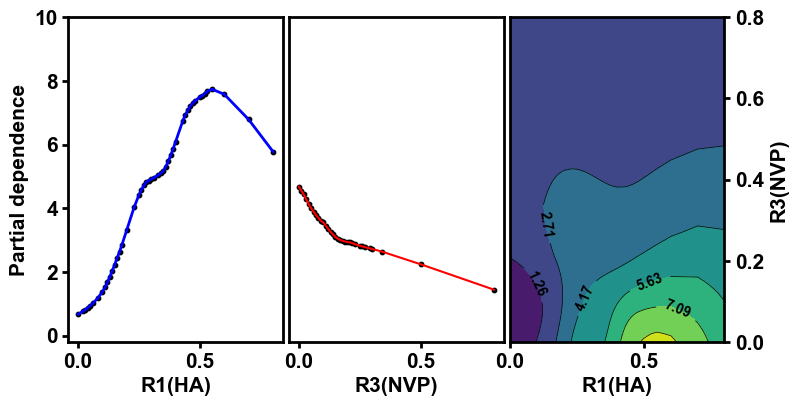

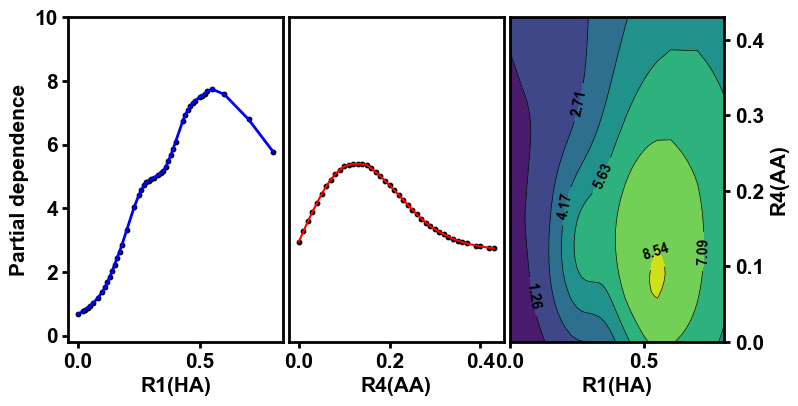

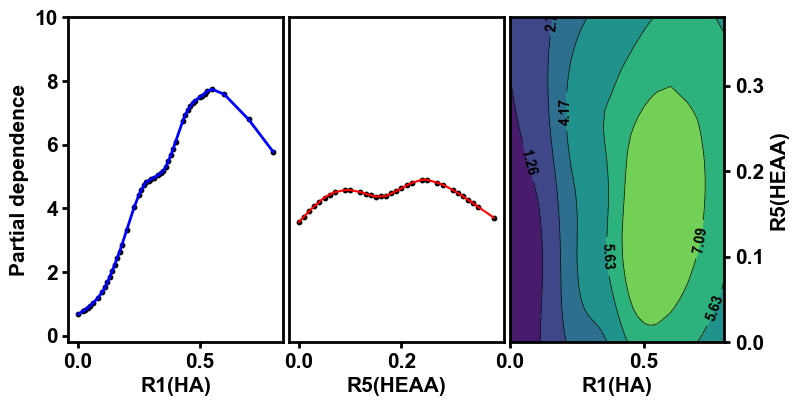

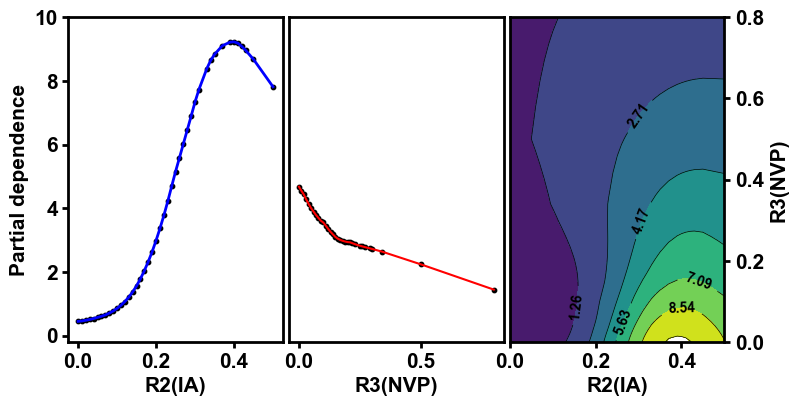

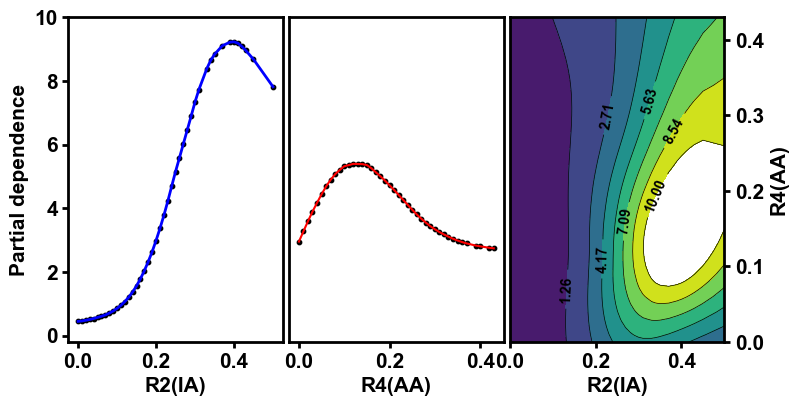

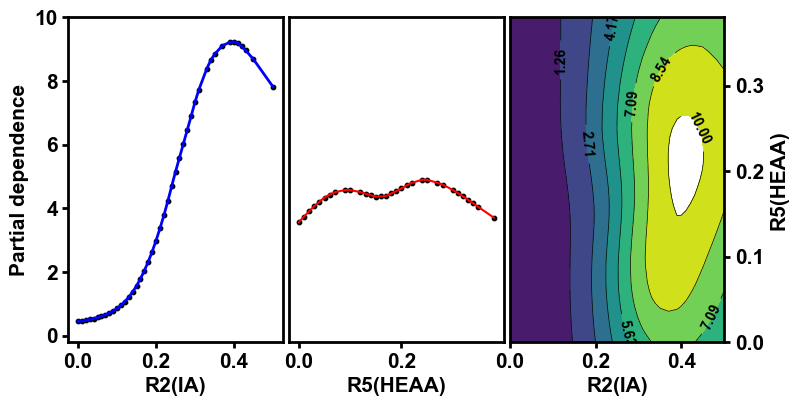

In [184]:
X_ratios = df.iloc[:, 1:6]
for soft, hard in itertools.product(range(0, 2), range(2, 5)):
    fig, ax = plt.subplots(1, 3, figsize=(8, 4), )  # constrained_layout=True)

    min_z, max_z = -0.2, 10
    # R1
    ratio_count = soft
    pd_results = partial_dependence(gpr_toughness, X_ratios, features=[ratio_count],
                                    grid_resolution=100, percentiles=(0.05, 0.095))
    ratio = np.array(pd_results["values"])[0]
    part_dep = np.array(pd_results["average"])[0]

    ax_ = ax[0]
    ax_.plot(ratio, part_dep, color='blue', markersize=20, linewidth=2)
    ax_.scatter(ratio, part_dep, color='black', s=10,)
    ax_.tick_params(direction='out', length=4, width=2, colors='black',
                    grid_alpha=1, labelsize='15')
    ax_.set_xlabel('{}'.format(Ratios[ratio_count]), fontweight='bold',
                   fontsize=15, fontname='Arial')
    ax_.set_ylabel('Partial dependence', fontsize=15,
                   fontname='Arial', fontweight='bold',)
    ax_.set_ylim(min_z, max_z)
    ratio1 = Ratios[ratio_count]
    # R4
    ratio_count = hard
    pd_results = partial_dependence(gpr_toughness, X_ratios, features=[ratio_count],
                                    grid_resolution=100, percentiles=(0, 1))
    ratio = np.array(pd_results["values"])[0]
    part_dep = np.array(pd_results["average"])[0]

    ax_ = ax[1]
    ax_.plot(ratio, part_dep, color='red', markersize=15)
    ax_.scatter(ratio, part_dep, color='black', s=10,)
    ax_.set_yticklabels([])
    ax_.tick_params('x', direction='out', length=4, width=2, colors='black',
                    grid_alpha=1, labelsize='15')
    ax_.tick_params('y', direction='out', length=0, width=0, colors='black',
                    grid_alpha=1, labelsize='15')

    ax_.set_xlabel('{}'.format(Ratios[ratio_count]), fontweight='bold',
                   fontsize=15, fontname='Arial')
    ax_.set_ylabel('', fontsize=15,
                   fontname='Arial', fontweight='bold',)
    ax_.set_ylim(min_z, max_z)
    ratio2 = Ratios[ratio_count]

    # Interaction of R1 and R4
    ax_ = ax[2]
    ratio_count = 0
    X_ratios = df.iloc[:, 1: 6]
    features = [soft, hard]
    pd_inter_results = partial_dependence(gpr_toughness, X_ratios, features=features, method='brute',
                                          kind='average',
                                          grid_resolution=100, percentiles=(0.05, 0.095))

    XX, YY = np.meshgrid(
        pd_inter_results['values'][0], pd_inter_results['values'][1])
    Z = pd_inter_results['average'][0].T
    Z_level = np.linspace(min_z, max_z, num=8)
    CS = ax_.contour(XX, YY, Z, levels=Z_level, linewidths=0.5, colors="k")

    ax_.contourf(
        XX,
        YY,
        Z,
        levels=Z_level,
        vmin=Z_level[0],
        vmax=Z_level[-1],
    )
    ax_.yaxis.set_label_position("right")
    ax_.yaxis.tick_right()

    ax_.tick_params(direction='out', length=4, width=2, colors='black',
                    grid_alpha=1, labelsize='15')
    ax_.set_xlabel('{}'.format(Ratios[soft]), fontweight='bold',
                   fontsize=15, fontname='Arial')
    ax_.set_ylabel('{}'.format(Ratios[hard]), fontweight='bold',
                   fontsize=15, fontname='Arial')
    ax_.clabel(CS, fmt="%2.2f", colors="k", fontsize=10, inline=True)
    # save the figure
    fig.subplots_adjust(left=0.08, right=0.9, bottom=0.138, top=0.95,
                        hspace=0.02, wspace=0.03)
    # plt.tight_layout()
    plt.savefig('pd_tough_{}_{}'.format(ratio1, ratio2), dpi=500)


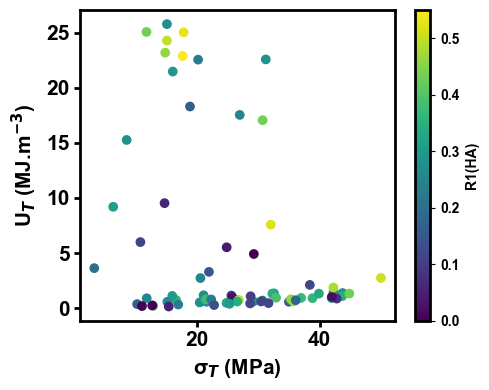

In [167]:
# plot two objectives with Ratios as colors
fig, ax = plt.subplots(figsize=(5, 4))
plt.scatter(x='Tensile_Strength(MPa)',
                y='Toughness(MJ/m3)', c='R1(HA)', data=df_eval)

cbar = plt.colorbar()

# Add labels and title
plt.xlabel('Sum of soft monomers', fontweight='bold', fontsize=15)
plt.ylabel('Sum of 3 hard monomers', fontweight='bold', fontsize=15)

ax.set_xlabel('σ$_{T}$ (MPa)', fontsize='15',
              fontname='Arial', fontweight='bold', labelpad=5)
ax.set_ylabel(r'U$_T$ (MJ.m$^{-3}$)', fontsize='15',
              fontname='Arial', fontweight='bold', labelpad=5)
ax.tick_params(direction='out', length=4, width=2, colors='black',
               grid_alpha=1, labelsize='15')
cbar.set_label('R1(HA)', fontweight = 'bold', fontsize=10)#rotation=270)
plt.tight_layout()
plt.savefig('contourplot_soft_hard.png', dpi=500)

In [168]:
df_eval

,sample,R1(HA),R2(IA),R3(NVP),R4(AA),R5(HEAA),R6(IBOA),Printability,Tg,Tensile_Strength(MPa),Toughness(MJ/m3),Tensile_Strain_percentage,tsne1,tsne2,pca1,pca2,initial,soft,hard
0,44,0.29,0.00,0.06,0.23,0.31,0.11,1,56.4,29.22,0.62,3.20,-6.951508,-19.622292,-0.077364,0.207555,Eval.,0.29,0.60
1,45,0.23,0.00,0.07,0.31,0.33,0.06,1,60.8,30.68,0.70,4.24,-9.083335,-18.246260,-0.003977,0.266009,Eval.,0.23,0.71
2,46,0.37,0.17,0.10,0.04,0.20,0.12,1,44.2,36.98,0.94,4.40,14.406789,4.165526,-0.125444,-0.049165,Eval.,0.54,0.34
3,47,0.25,0.35,0.02,0.15,0.13,0.10,1,29.2,26.97,17.53,97.20,0.881926,10.403777,0.056874,-0.125230,Eval.,0.60,0.30
4,48,0.29,0.28,0.04,0.29,0.10,0.00,1,36.7,32.56,1.35,6.16,-7.868213,0.430284,0.024807,0.000154,Eval.,0.57,0.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,111,0.11,0.02,0.00,0.34,0.19,0.34,1,65.8,30.46,0.62,3.80,-16.657022,-9.509528,0.090317,0.270511,Eval.,0.13,0.53
66,112,0.43,0.22,0.15,0.13,0.05,0.02,1,39.3,44.84,1.33,5.36,10.756840,-4.484246,-0.145156,-0.054346,Eval.,0.65,0.33
67,113,0.52,0.21,0.05,0.11,0.09,0.02,1,35.7,32.03,7.58,33.28,16.302450,-3.518289,-0.242724,-0.087237,Eval.,0.73,0.25
68,114,0.13,0.19,0.03,0.43,0.06,0.16,1,56.4,22.79,0.29,3.40,-13.487068,-2.462492,0.152901,0.175987,Eval.,0.32,0.52


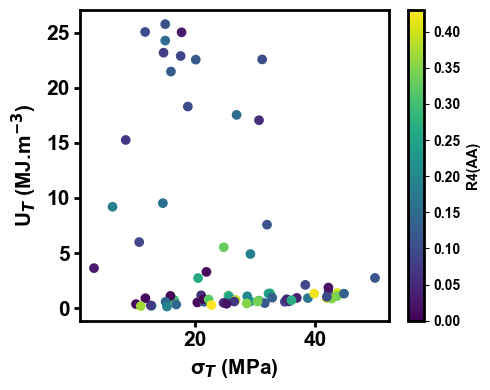

In [169]:
# plot two objectives with Ratios as colors
fig, ax = plt.subplots(figsize=(5, 4))
plt.scatter(x='Tensile_Strength(MPa)',
                y='Toughness(MJ/m3)', c='R4(AA)', data=df_eval)

cbar = plt.colorbar()

# Add labels and title
plt.xlabel('Sum of soft monomers', fontweight='bold', fontsize=15)
plt.ylabel('Sum of 3 hard monomers', fontweight='bold', fontsize=15)

ax.set_xlabel('σ$_{T}$ (MPa)', fontsize='15',
              fontname='Arial', fontweight='bold', labelpad=5)
ax.set_ylabel(r'U$_T$ (MJ.m$^{-3}$)', fontsize='15',
              fontname='Arial', fontweight='bold', labelpad=5)
ax.tick_params(direction='out', length=4, width=2, colors='black',
               grid_alpha=1, labelsize='15')
cbar.set_label('R4(AA)', fontweight = 'bold', fontsize=10)#rotation=270)
plt.tight_layout()
plt.savefig('contourplot_soft_hard.png', dpi=500)

In [170]:
X_simulated = []
random.seed(10)


def generate_random_numbers_sum_between_zero_and_one(n):
    while True:
        numbers = [random.uniform(0, 1) for _ in range(n)]
        total_sum = sum(numbers)

        if 0 < total_sum < 1:
            return numbers


dimension = 2**2
for seed in range(dimension):
    random_numbers = generate_random_numbers_sum_between_zero_and_one(5,)
    X_simulated.append(random_numbers)

    #print("Generated random numbers:", random_numbers)
    #print("Sum:", sum(random_numbers))

X_sim = np.array(X_simulated)
strength_sim0 = gpr_strength.predict(X_sim)
print(strength_sim0.shape)
Z = strength_sim0.reshape(int(np.sqrt(dimension)), int(np.sqrt(dimension)))
x = X_sim[:, 0].ravel() + X_sim[:, 1].ravel()
y = X_sim[:, 2].ravel() + X_sim[:, 3].ravel() + X_sim[:, 4].ravel()
X = x.reshape(int(np.sqrt(dimension)), int(np.sqrt(dimension)))
Y = y.reshape(int(np.sqrt(dimension)), int(np.sqrt(dimension)))


(4,)


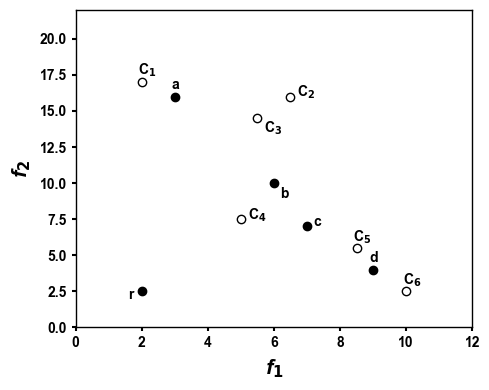

In [171]:

Xs = [3, 6, 7, 9, 2]
Ys = [16, 10, 7, 4, 2.5]
fig, ax = plt.subplots(figsize=(5, 4))
plt.scatter(Xs, Ys, color='black')
list = ['a', 'b', 'c', 'd', 'r']
shiftx = [-0.1, +0.2, 0.2, -0.1, -0.4]
shifty = [0.5, -1, 0., 0.5, -0.5, ]
for i, txt in enumerate(list):
    ax.annotate(txt, (Xs[i] + shiftx[i], Ys[i] + shifty[i]))
plt.xlim(0, 12)
plt.ylim(0, 22)

[i.set_linewidth(1) for i in ax.spines.values()]

XCs = [2, 5.5, 6.5, 5, 8.5, 10]
YCs = [17, 14.5, 16, 7.5, 5.5, 2.5]

shiftx = [-0.1, +0.2, 0.2, 0.2, -0.1, -0.1]
shifty = [0.5, -1, 0., 0., 0.45, 0.5]

plt.scatter(XCs, YCs, color='white', edgecolors='black')
list = [r'C$_1$', r'C$_3$', r'C$_2$', r'C$_4$', r'C$_5$', r'C$_6$']
for i, txt in enumerate(list):
    ax.annotate(txt, (XCs[i]+shiftx[i], YCs[i]+shifty[i]), fontsize=10)
ax.set_xlabel(r'f$_1$', style='italic', fontsize='15',
              fontname='Arial', fontweight='bold', labelpad=5)
ax.set_ylabel(r'f$_2$', style='italic', fontsize='15',
              fontname='Arial', fontweight='bold', labelpad=5)
ax.tick_params(axis='both', length=3, width=1.5,
               colors='black', grid_alpha=0, labelsize=10)

plt.tight_layout()
plt.savefig('EHVI_simulated_graph.png', dpi=500)


In [172]:
df

,sample,R1(HA),R2(IA),R3(NVP),R4(AA),R5(HEAA),R6(IBOA),Printability,Tensile_Strength(MPa),Tensile_Strain_percentage,...,Youngs_Modulus(MPa),Tg,sum_softmon,sum_hardmon,sum,tsne1,tsne2,pca1,pca2,initial
0,1,0.15,0.20,0.02,0.21,0.18,0.24,NaN,45.51,7.10,...,1300.199,56.6,0.35,0.65,1.0,0.510834,-5.260442,-0.093719,-0.054304,Initial
1,2,0.25,0.31,0.11,0.02,0.16,0.15,NaN,17.95,96.87,...,503.150,14.2,0.56,0.44,1.0,-17.501356,2.524794,0.041478,-0.100606,Initial
2,3,0.06,0.17,0.27,0.11,0.27,0.12,NaN,32.74,3.79,...,924.700,54.8,0.23,0.77,1.0,-3.057491,-29.406973,-0.244976,0.028596,Initial
3,4,0.00,0.10,0.30,0.20,0.20,0.20,NaN,27.81,3.79,...,1404.640,56.7,0.10,0.90,1.0,-8.452329,-33.603291,-0.321841,0.087575,Initial
4,5,0.35,0.35,0.00,0.00,0.10,0.20,NaN,1.20,400.28,...,0.608,13.1,0.70,0.30,1.0,-18.640648,15.556582,0.187369,-0.146428,Initial
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,111,0.11,0.02,0.00,0.34,0.19,0.34,1.0,30.46,3.80,...,NaN,65.8,NaN,NaN,NaN,-16.657022,-9.509528,-0.189302,0.093145,Eval.
66,112,0.43,0.22,0.15,0.13,0.05,0.02,1.0,44.84,5.36,...,NaN,39.3,NaN,NaN,NaN,10.756840,-4.484246,0.171217,0.052873,Eval.
67,113,0.52,0.21,0.05,0.11,0.09,0.02,1.0,32.03,33.28,...,NaN,35.7,NaN,NaN,NaN,16.302450,-3.518289,0.270360,0.052597,Eval.
68,114,0.13,0.19,0.03,0.43,0.06,0.16,1.0,22.79,3.40,...,NaN,56.4,NaN,NaN,NaN,-13.487068,-2.462492,-0.142361,-0.036144,Eval.


In [173]:
df

,sample,R1(HA),R2(IA),R3(NVP),R4(AA),R5(HEAA),R6(IBOA),Printability,Tensile_Strength(MPa),Tensile_Strain_percentage,...,Youngs_Modulus(MPa),Tg,sum_softmon,sum_hardmon,sum,tsne1,tsne2,pca1,pca2,initial
0,1,0.15,0.20,0.02,0.21,0.18,0.24,NaN,45.51,7.10,...,1300.199,56.6,0.35,0.65,1.0,0.510834,-5.260442,-0.093719,-0.054304,Initial
1,2,0.25,0.31,0.11,0.02,0.16,0.15,NaN,17.95,96.87,...,503.150,14.2,0.56,0.44,1.0,-17.501356,2.524794,0.041478,-0.100606,Initial
2,3,0.06,0.17,0.27,0.11,0.27,0.12,NaN,32.74,3.79,...,924.700,54.8,0.23,0.77,1.0,-3.057491,-29.406973,-0.244976,0.028596,Initial
3,4,0.00,0.10,0.30,0.20,0.20,0.20,NaN,27.81,3.79,...,1404.640,56.7,0.10,0.90,1.0,-8.452329,-33.603291,-0.321841,0.087575,Initial
4,5,0.35,0.35,0.00,0.00,0.10,0.20,NaN,1.20,400.28,...,0.608,13.1,0.70,0.30,1.0,-18.640648,15.556582,0.187369,-0.146428,Initial
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,111,0.11,0.02,0.00,0.34,0.19,0.34,1.0,30.46,3.80,...,NaN,65.8,NaN,NaN,NaN,-16.657022,-9.509528,-0.189302,0.093145,Eval.
66,112,0.43,0.22,0.15,0.13,0.05,0.02,1.0,44.84,5.36,...,NaN,39.3,NaN,NaN,NaN,10.756840,-4.484246,0.171217,0.052873,Eval.
67,113,0.52,0.21,0.05,0.11,0.09,0.02,1.0,32.03,33.28,...,NaN,35.7,NaN,NaN,NaN,16.302450,-3.518289,0.270360,0.052597,Eval.
68,114,0.13,0.19,0.03,0.43,0.06,0.16,1.0,22.79,3.40,...,NaN,56.4,NaN,NaN,NaN,-13.487068,-2.462492,-0.142361,-0.036144,Eval.


In [174]:
df['Tensile_Strain_percentage']

0       7.10
1      96.87
2       3.79
3       3.79
4     400.28
       ...  
65      3.80
66      5.36
67     33.28
68      3.40
69    141.20
Name: Tensile_Strain_percentage, Length: 106, dtype: float64

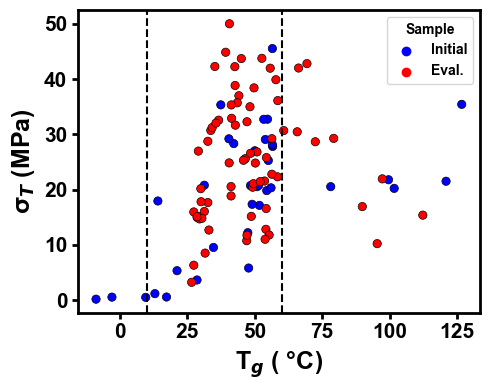

In [175]:
df['Sample'] = df['initial']
fig, ax = plt.subplots(figsize=(5, 4))
sns.scatterplot(data=df, x='Tg', y='Tensile_Strength(MPa)', palette=['blue','red'],
                hue='Sample',   edgecolor='black', )

ax.set_ylabel('σ$_{T}$ (MPa)', fontsize='18',
              fontname='Arial', fontweight='bold', labelpad=5)
ax.set_xlabel(r'T$_g$ ( °C)', fontsize='18',
              fontname='Arial', fontweight='bold', labelpad=5)
ax.tick_params(direction='out', length=4, width=2, colors='black',
               grid_alpha=1, labelsize='15')
plt.axvline(x=10, linestyle="--", color='k',)
plt.axvline(x=60, linestyle="--", color='k',)
plt.tight_layout()
plt.savefig('Tg_Strength.png', dpi=500)

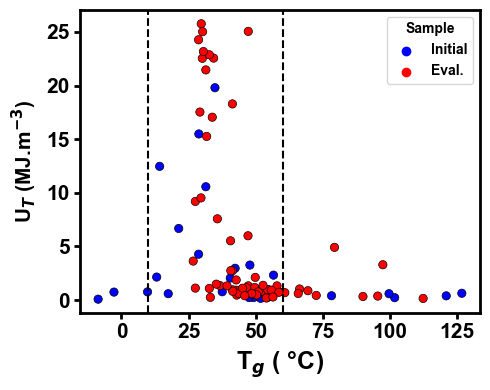

In [176]:
df['Sample'] = df['initial']
fig, ax = plt.subplots(figsize=(5, 4))
sns.scatterplot(x='Tg', y='Toughness(MJ/m3)', hue='Sample', data=df, 
                edgecolor='black', palette=['blue','red'],)

ax.set_ylabel(r'U$_T$ (MJ.m$^{-3}$)', fontsize='15',
              fontname='Arial', fontweight='bold', labelpad=5)
ax.set_xlabel(r'T$_g$ ( °C)', fontsize='18',
              fontname='Arial', fontweight='bold', labelpad=5)
ax.tick_params(direction='out', length=4, width=2, colors='black',
               grid_alpha=1, labelsize='15')
plt.axvline(x=10, linestyle="--", color='k',)
plt.axvline(x=60, linestyle="--", color='k',)
plt.tight_layout()
plt.savefig('Tg_Toughness.png', dpi=500)

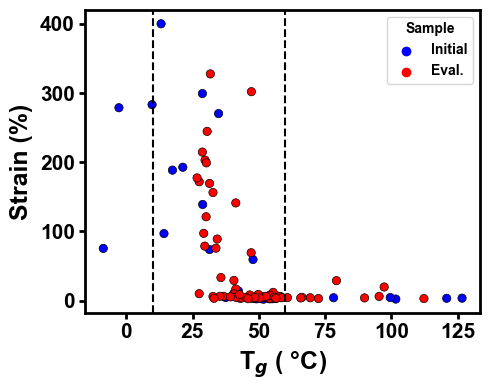

In [177]:
df['Sample'] = df['initial']
fig, ax = plt.subplots(figsize=(5, 4))
sns.scatterplot(x='Tg', y='Tensile_Strain_percentage', hue='Sample', 
                data=df, edgecolor='black', palette=['blue','red'],)

ax.set_ylabel('Strain (%)', fontsize='18',
              fontname='Arial', fontweight='bold', labelpad=5)
ax.set_xlabel(r'T$_g$ ( °C)', fontsize='18',
              fontname='Arial', fontweight='bold', labelpad=5)
ax.tick_params(direction='out', length=4, width=2, colors='black',
               grid_alpha=1, labelsize='15')
plt.axvline(x=10, linestyle="--", color='k',)
plt.axvline(x=60, linestyle="--", color='k',)
plt.tight_layout()
plt.savefig('Tg_Strain.png', dpi=500)

In [178]:
df

,sample,R1(HA),R2(IA),R3(NVP),R4(AA),R5(HEAA),R6(IBOA),Printability,Tensile_Strength(MPa),Tensile_Strain_percentage,...,Tg,sum_softmon,sum_hardmon,sum,tsne1,tsne2,pca1,pca2,initial,Sample
0,1,0.15,0.20,0.02,0.21,0.18,0.24,NaN,45.51,7.10,...,56.6,0.35,0.65,1.0,0.510834,-5.260442,-0.093719,-0.054304,Initial,Initial
1,2,0.25,0.31,0.11,0.02,0.16,0.15,NaN,17.95,96.87,...,14.2,0.56,0.44,1.0,-17.501356,2.524794,0.041478,-0.100606,Initial,Initial
2,3,0.06,0.17,0.27,0.11,0.27,0.12,NaN,32.74,3.79,...,54.8,0.23,0.77,1.0,-3.057491,-29.406973,-0.244976,0.028596,Initial,Initial
3,4,0.00,0.10,0.30,0.20,0.20,0.20,NaN,27.81,3.79,...,56.7,0.10,0.90,1.0,-8.452329,-33.603291,-0.321841,0.087575,Initial,Initial
4,5,0.35,0.35,0.00,0.00,0.10,0.20,NaN,1.20,400.28,...,13.1,0.70,0.30,1.0,-18.640648,15.556582,0.187369,-0.146428,Initial,Initial
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,111,0.11,0.02,0.00,0.34,0.19,0.34,1.0,30.46,3.80,...,65.8,NaN,NaN,NaN,-16.657022,-9.509528,-0.189302,0.093145,Eval.,Eval.
66,112,0.43,0.22,0.15,0.13,0.05,0.02,1.0,44.84,5.36,...,39.3,NaN,NaN,NaN,10.756840,-4.484246,0.171217,0.052873,Eval.,Eval.
67,113,0.52,0.21,0.05,0.11,0.09,0.02,1.0,32.03,33.28,...,35.7,NaN,NaN,NaN,16.302450,-3.518289,0.270360,0.052597,Eval.,Eval.
68,114,0.13,0.19,0.03,0.43,0.06,0.16,1.0,22.79,3.40,...,56.4,NaN,NaN,NaN,-13.487068,-2.462492,-0.142361,-0.036144,Eval.,Eval.


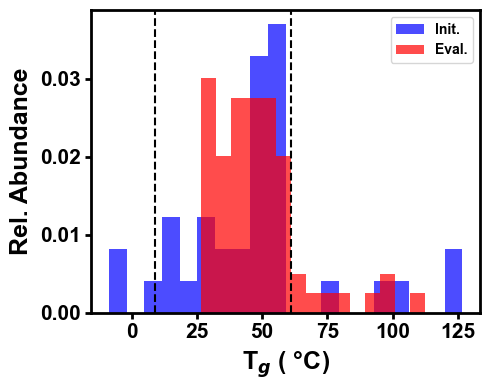

In [179]:
# barplot Tg
fig, ax = plt.subplots(figsize=(5, 4))

ax.set_xlabel(r'T$_g$ ( °C)', fontsize='18', 
              fontname='Arial', fontweight='bold', labelpad=5)
ax.set_ylabel('Rel. Abundance', fontsize='18', 
              fontname='Arial', fontweight='bold', labelpad=5)
ax.tick_params(direction='out', length=4, width=2, colors='black',
               grid_alpha=1, labelsize='15')
colors=['red', 'blue']
#bins=[-10, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, ]
hist_init = plt.hist(df['Tg'].loc[df['initial']=='Initial'], bins=20, color='blue', density=True, 
         alpha=0.7, label='Init.', )
hist_eval = plt.hist(df['Tg'].loc[df['initial']=='Eval.'], bins=15, color='red', density=True, 
         alpha=0.7, label='Eval.')
plt.axvline(x=9, linestyle="--", color='k',)
plt.axvline(x=61, linestyle="--", color='k',)
plt.legend()

plt.tight_layout()
plt.savefig('Tg_bins.png', dpi=500)

In [180]:
print ('!!!!!!Done!!!!!!')

!!!!!!Done!!!!!!
